# Stock Market EDA & Visualization (Phần 2)

## Mục tiêu:
- Phân tích dữ liệu khám phá (EDA) cho dữ liệu chứng khoán
- **Phân tích fundamental data (business & finance) và tương quan với giá**
- Tạo các biểu đồ trực quan hóa:
  - Line chart giá đóng cửa theo thời gian **với Moving Averages**
  - Candlestick chart (biểu đồ nến)
  - Volume giao dịch theo ngày
  - Daily returns distribution
  - **Autocorrelation Analysis (ACF/PACF) cho time series**
  - Heatmap tương quan
- **Phân tích xu hướng với MA crossover signals**
- Rút ra insights quan trọng từ dữ liệu

In [1]:
# Import các thư viện cần thiết
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import warnings
warnings.filterwarnings('ignore')

# Thiết lập style cho matplotlib
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Cấu hình hiển thị
pd.set_option('display.max_columns', None)
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

In [2]:
# Cài đặt các thư viện cần thiết
%pip install pandas numpy matplotlib seaborn plotly statsmodels nbformat ipython jupyter
print("✓ Đã cài đặt xong các thư viện!")

Note: you may need to restart the kernel to use updated packages.
✓ Đã cài đặt xong các thư viện!



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


## 1. Load và khám phá dữ liệu

In [3]:
# Load dữ liệu
price_train = pd.read_csv('price_train.csv')
price_test = pd.read_csv('price_test.csv')
business_train = pd.read_csv('business_train.csv')
finance_train = pd.read_csv('finance_train.csv')

print("=== Thông tin cơ bản về dữ liệu ===")
print(f"Price Train Shape: {price_train.shape}")
print(f"Price Test Shape: {price_test.shape}")
print(f"Business Train Shape: {business_train.shape}")
print(f"Finance Train Shape: {finance_train.shape}")

print("\n=== Các cột trong price_train ===")
print(price_train.columns.tolist())

print("\n=== Kiểu dữ liệu ===")
print(price_train.dtypes)

print("\n=== Thống kê mô tả ===")
print(price_train.describe())

=== Thông tin cơ bản về dữ liệu ===
Price Train Shape: (6149, 7)
Price Test Shape: (630, 3)
Business Train Shape: (823, 5)
Finance Train Shape: (3421, 5)

=== Các cột trong price_train ===
['date', 'open', 'high', 'low', 'close', 'volume', 'symbol']

=== Kiểu dữ liệu ===
date       object
open      float64
high      float64
low       float64
close     float64
volume      int64
symbol     object
dtype: object

=== Thống kê mô tả ===
              open         high          low        close        volume
count  6149.000000  6149.000000  6149.000000  6149.000000  6.149000e+03
mean     63.614010    64.501293    62.723082    63.675337  7.264673e+06
std      35.827472    36.246300    35.379909    35.870068  9.218460e+06
min      10.200000    10.300000     9.980000    10.100000  1.706000e+05
25%      33.000000    33.700000    32.500000    33.100000  1.571600e+06
50%      54.000000    54.500000    53.000000    53.900000  3.623700e+06
75%      93.300000    94.600000    92.100000    93.400000  9

Số lượng mã cổ phiếu: 30
Các mã cổ phiếu: ['STB' 'SSI' 'TCB' 'VPB' 'HPG' 'MBB' 'POW' 'CTG' 'TCH' 'HDB' 'VHM' 'VRE'
 'VIC' 'SBT' 'NVL' 'PDR' 'BID' 'VNM' 'PLX' 'TPB' 'MWG' 'FPT' 'PNJ' 'MSN'
 'KDH' 'GAS' 'BVH' 'VJC' 'VCB' 'REE']

=== Phân phối dữ liệu theo symbol ===
symbol
STB    205
SSI    205
TCB    205
VPB    205
HPG    205
MBB    205
POW    205
CTG    205
TCH    205
HDB    205
VHM    205
VRE    205
VIC    205
SBT    205
PDR    205
BID    205
VNM    205
PLX    205
MWG    205
TPB    205
FPT    205
PNJ    205
BVH    205
MSN    205
KDH    205
GAS    205
VCB    205
VJC    205
REE    205
NVL    204
Name: count, dtype: int64


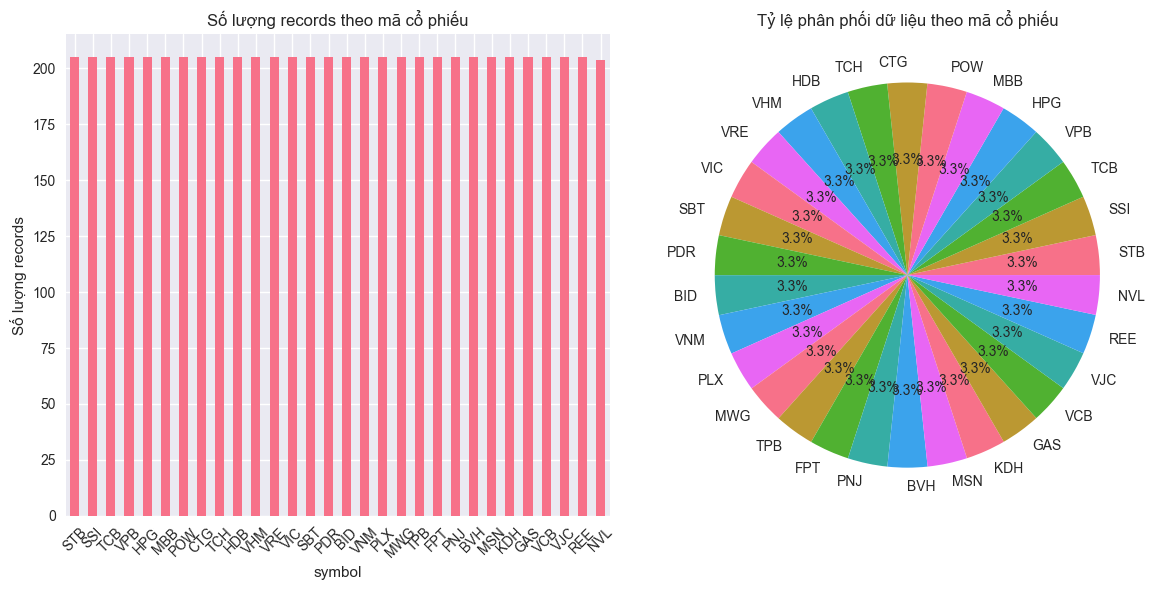

In [4]:
# Kiểm tra các symbol (mã cổ phiếu) có trong dữ liệu
symbols = price_train['symbol'].unique()
print(f"Số lượng mã cổ phiếu: {len(symbols)}")
print(f"Các mã cổ phiếu: {symbols}")

# Kiểm tra phân phối dữ liệu theo symbol
symbol_counts = price_train['symbol'].value_counts()
print("\n=== Phân phối dữ liệu theo symbol ===")
print(symbol_counts)

# Biểu đồ phân phối số lượng record theo symbol
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
symbol_counts.plot(kind='bar')
plt.title('Số lượng records theo mã cổ phiếu')
plt.ylabel('Số lượng records')
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
plt.pie(symbol_counts.values, labels=symbol_counts.index, autopct='%1.1f%%')
plt.title('Tỷ lệ phân phối dữ liệu theo mã cổ phiếu')

plt.tight_layout()
plt.show()

## 2. Tiền xử lý dữ liệu

In [5]:
# Chuyển đổi cột date thành datetime
price_train['date'] = pd.to_datetime(price_train['date'])
price_test['date'] = pd.to_datetime(price_test['date'])

# Sắp xếp theo thời gian tăng dần
price_train = price_train.sort_values(['symbol', 'date']).reset_index(drop=True)
price_test = price_test.sort_values(['symbol', 'date']).reset_index(drop=True)

# Kiểm tra missing values
print("=== Missing values trong price_train ===")
print(price_train.isnull().sum())

print("\n=== Khoảng thời gian dữ liệu ===")
print(f"Từ: {price_train['date'].min()}")
print(f"Đến: {price_train['date'].max()}")
print(f"Tổng số ngày: {(price_train['date'].max() - price_train['date'].min()).days}")

=== Missing values trong price_train ===
date      0
open      0
high      0
low       0
close     0
volume    0
symbol    0
dtype: int64

=== Khoảng thời gian dữ liệu ===
Từ: 2021-01-04 00:00:00
Đến: 2021-10-29 00:00:00
Tổng số ngày: 298


In [6]:
# Tạo các biến mới cho phân tích
def calculate_technical_features(df):
    """
    Tính toán các features kỹ thuật cơ bản
    """
    df = df.copy()
    
    # Sắp xếp theo symbol và date
    df = df.sort_values(['symbol', 'date'])
    
    # Tính toán cho từng symbol
    for symbol in df['symbol'].unique():
        mask = df['symbol'] == symbol
        symbol_data = df[mask].copy()
        
        # Daily return (% thay đổi hàng ngày)
        symbol_data['daily_return'] = symbol_data['close'].pct_change()
        
        # Price range (high - low)
        symbol_data['price_range'] = symbol_data['high'] - symbol_data['low']
        
        # Body của nến (close - open)
        symbol_data['candle_body'] = symbol_data['close'] - symbol_data['open']
        
        # Upper shadow (high - max(open, close))
        symbol_data['upper_shadow'] = symbol_data['high'] - symbol_data[['open', 'close']].max(axis=1)
        
        # Lower shadow (min(open, close) - low)
        symbol_data['lower_shadow'] = symbol_data[['open', 'close']].min(axis=1) - symbol_data['low']
        
        # Label tăng/giảm (1 nếu tăng, 0 nếu giảm)
        symbol_data['label_up_down'] = (symbol_data['close'] > symbol_data['open']).astype(int)
        
        # Cập nhật lại vào dataframe gốc
        df.loc[mask, ['daily_return', 'price_range', 'candle_body', 'upper_shadow', 
                      'lower_shadow', 'label_up_down']] = symbol_data[['daily_return', 'price_range', 
                                                                       'candle_body', 'upper_shadow', 
                                                                       'lower_shadow', 'label_up_down']]
    
    return df

# Áp dụng tính toán features
price_train_enhanced = calculate_technical_features(price_train)

print("=== Dữ liệu sau khi thêm features ===")
print(price_train_enhanced.head())
print(f"\nShape mới: {price_train_enhanced.shape}")
print(f"Các cột mới: {price_train_enhanced.columns.tolist()}")

=== Dữ liệu sau khi thêm features ===
        date   open   high    low  close   volume symbol  daily_return  \
0 2021-01-04  47.75  48.45  47.75  48.25  1993800    BID           NaN   
1 2021-01-05  47.90  48.10  47.65  47.90  2155700    BID     -0.007254   
2 2021-01-06  48.30  50.60  47.55  48.80  3674500    BID      0.018789   
3 2021-01-07  48.80  49.90  48.50  48.90  1781500    BID      0.002049   
4 2021-01-08  49.30  49.30  48.20  48.50  2034900    BID     -0.008180   

   price_range  candle_body  upper_shadow  lower_shadow  label_up_down  
0         0.70          0.5           0.2          0.00            1.0  
1         0.45          0.0           0.2          0.25            0.0  
2         3.05          0.5           1.8          0.75            1.0  
3         1.40          0.1           1.0          0.30            1.0  
4         1.10         -0.8           0.0          0.30            0.0  

Shape mới: (6149, 13)
Các cột mới: ['date', 'open', 'high', 'low', 'close', 'v

## 3. Phân tích dữ liệu khám phá (EDA)

### 3.1. Biểu đồ giá đóng cửa theo thời gian (Line Chart)

In [7]:
# Chọn một vài mã cổ phiếu tiêu biểu để phân tích
top_symbols = price_train_enhanced['symbol'].value_counts().head(5).index.tolist()
print(f"Top 5 mã cổ phiếu có nhiều dữ liệu nhất: {top_symbols}")

# Biểu đồ line chart cho giá đóng cửa
fig = make_subplots(
    rows=len(top_symbols), cols=1,
    subplot_titles=[f'Giá đóng cửa - {symbol}' for symbol in top_symbols],
    vertical_spacing=0.08
)

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']

for i, symbol in enumerate(top_symbols):
    symbol_data = price_train_enhanced[price_train_enhanced['symbol'] == symbol]
    
    fig.add_trace(
        go.Scatter(
            x=symbol_data['date'],
            y=symbol_data['close'],
            mode='lines',
            name=symbol,
            line=dict(color=colors[i], width=2)
        ),
        row=i+1, col=1
    )

fig.update_layout(
    height=300*len(top_symbols),
    title_text="Xu hướng giá đóng cửa theo thời gian",
    title_x=0.5,
    showlegend=False
)

fig.update_xaxes(title_text="Thời gian")
fig.update_yaxes(title_text="Giá đóng cửa (VND)")

fig.show()

Top 5 mã cổ phiếu có nhiều dữ liệu nhất: ['BID', 'BVH', 'CTG', 'FPT', 'GAS']


Top 5 mã cổ phiếu: ['BID', 'BVH', 'CTG', 'FPT', 'GAS']


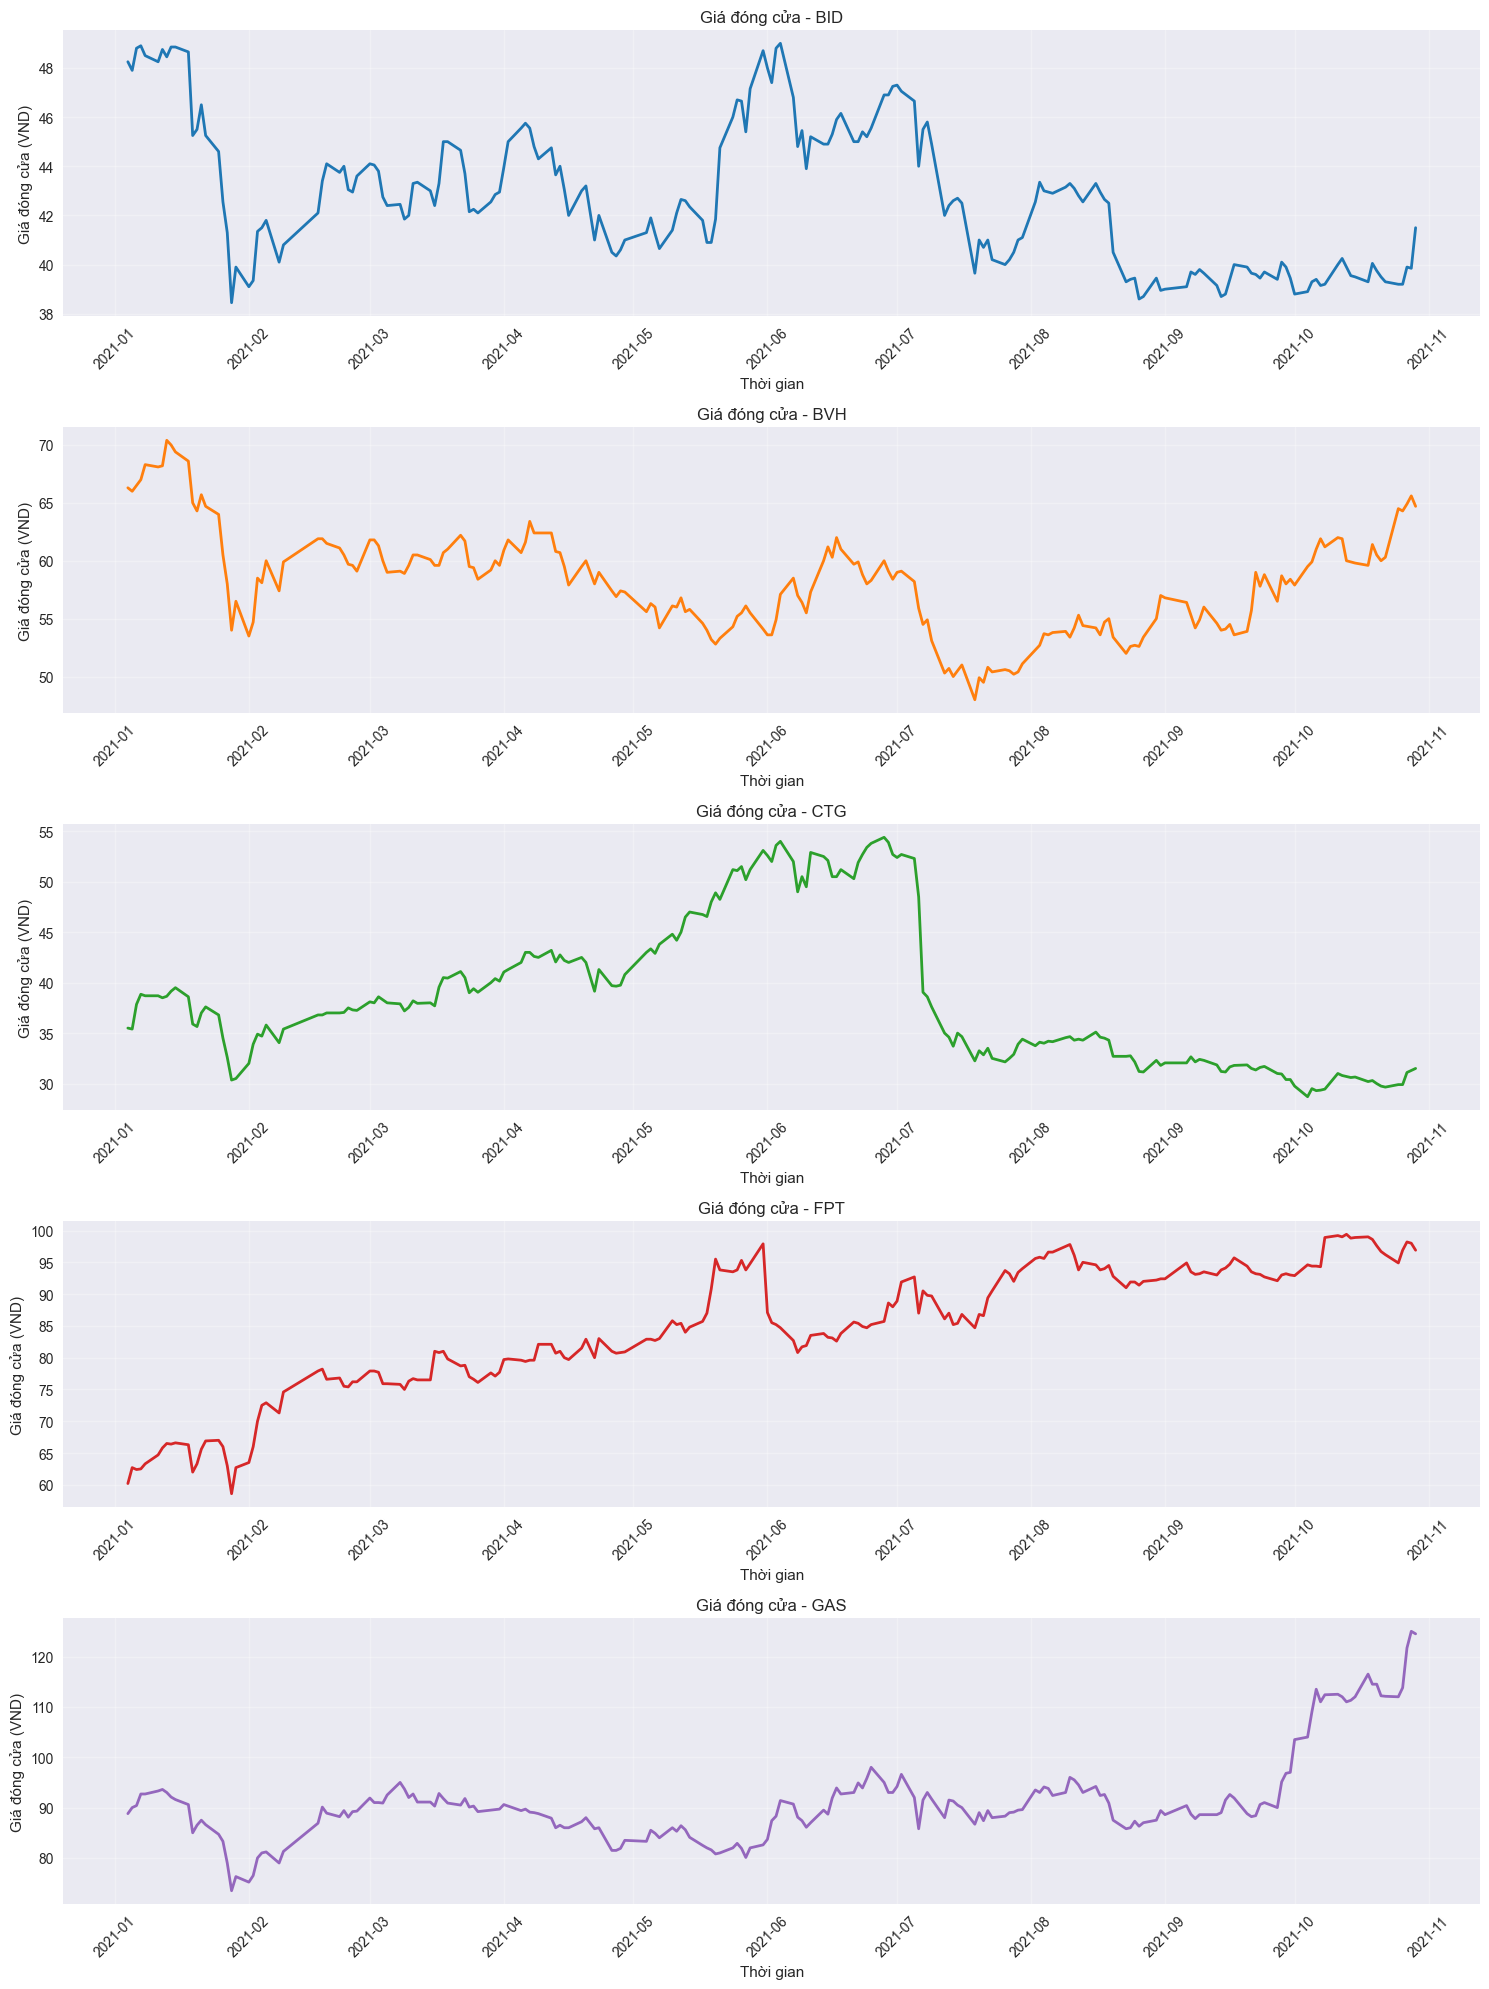

✓ Biểu đồ line chart đã được tạo thành công với matplotlib!


In [8]:
# Alternative: Sử dụng matplotlib cho biểu đồ line chart (tránh lỗi plotly)
print(f"Top 5 mã cổ phiếu: {top_symbols}")

fig, axes = plt.subplots(len(top_symbols), 1, figsize=(15, 4*len(top_symbols)))
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']

for i, symbol in enumerate(top_symbols):
    symbol_data = price_train_enhanced[price_train_enhanced['symbol'] == symbol]
    
    ax = axes[i] if len(top_symbols) > 1 else axes
    ax.plot(symbol_data['date'], symbol_data['close'], 
            color=colors[i], linewidth=2, label=symbol)
    ax.set_title(f'Giá đóng cửa - {symbol}', fontsize=12)
    ax.set_xlabel('Thời gian')
    ax.set_ylabel('Giá đóng cửa (VND)')
    ax.grid(True, alpha=0.3)
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()
print("✓ Biểu đồ line chart đã được tạo thành công với matplotlib!")

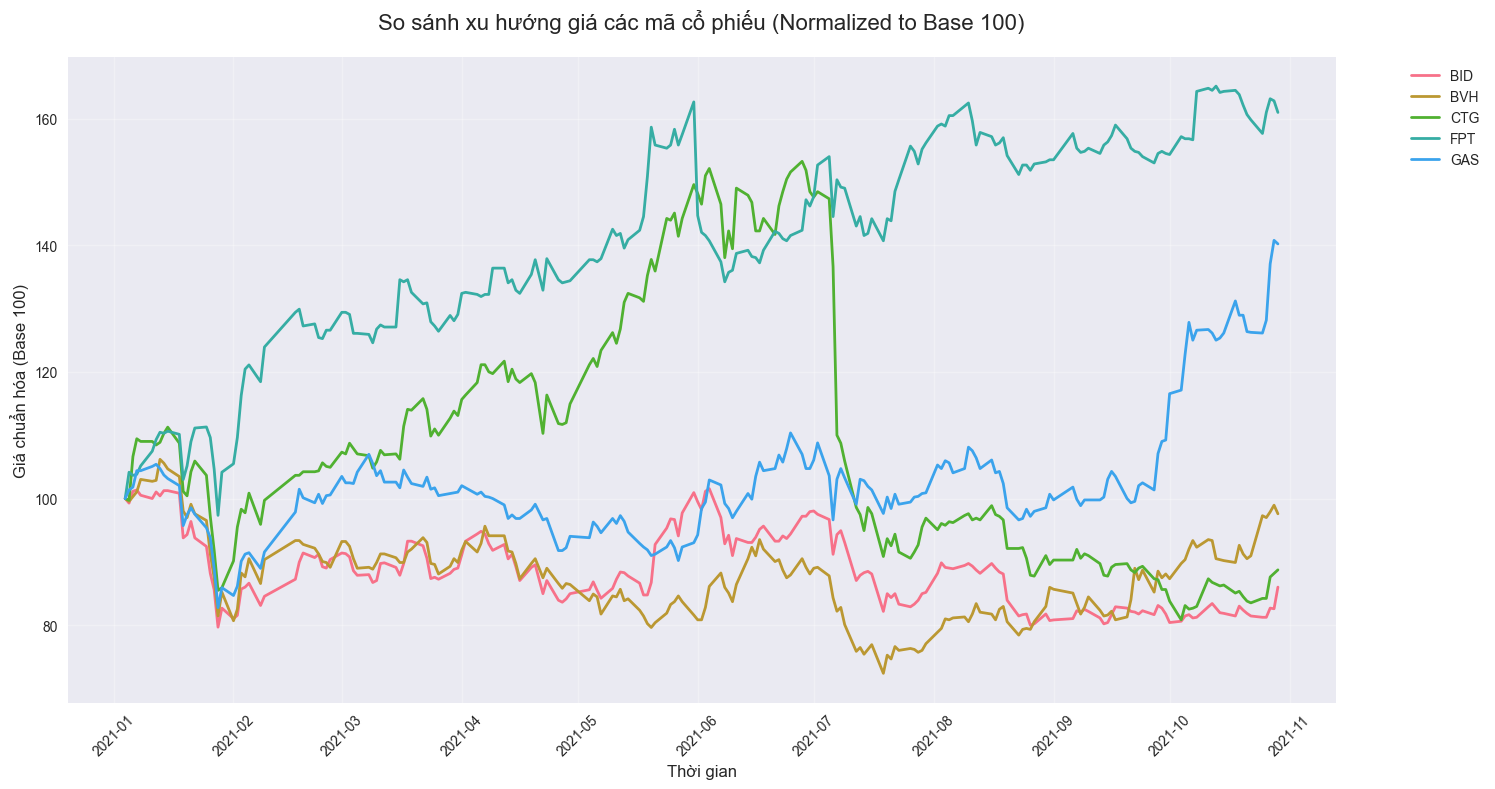

In [9]:
# Biểu đồ so sánh tất cả các mã cổ phiếu trên cùng một chart (normalized)
plt.figure(figsize=(15, 8))

for symbol in top_symbols:
    symbol_data = price_train_enhanced[price_train_enhanced['symbol'] == symbol].copy()
    
    # Normalize giá về base 100 (giá đầu tiên = 100)
    if len(symbol_data) > 0:
        symbol_data['normalized_price'] = (symbol_data['close'] / symbol_data['close'].iloc[0]) * 100
        plt.plot(symbol_data['date'], symbol_data['normalized_price'], label=symbol, linewidth=2)

plt.title('So sánh xu hướng giá các mã cổ phiếu (Normalized to Base 100)', fontsize=16, pad=20)
plt.xlabel('Thời gian', fontsize=12)
plt.ylabel('Giá chuẩn hóa (Base 100)', fontsize=12)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### 3.2. Biểu đồ nến (Candlestick Chart)

In [10]:
# Tạo candlestick chart cho mã cổ phiếu có nhiều dữ liệu nhất
main_symbol = top_symbols[0]
symbol_data = price_train_enhanced[price_train_enhanced['symbol'] == main_symbol]

# Lấy dữ liệu 6 tháng gần nhất để hiển thị rõ hơn
recent_data = symbol_data.tail(120)  # ~6 tháng giao dịch

fig = make_subplots(
    rows=2, cols=1,
    subplot_titles=[f'Biểu đồ nến - {main_symbol}', 'Khối lượng giao dịch'],
    vertical_spacing=0.1,
    row_heights=[0.7, 0.3]
)

# Candlestick chart
fig.add_trace(
    go.Candlestick(
        x=recent_data['date'],
        open=recent_data['open'],
        high=recent_data['high'],
        low=recent_data['low'],
        close=recent_data['close'],
        name='Giá',
        increasing_line_color='#00ff00',
        decreasing_line_color='#ff0000'
    ),
    row=1, col=1
)

# Volume chart
fig.add_trace(
    go.Bar(
        x=recent_data['date'],
        y=recent_data['volume'],
        name='Volume',
        marker_color='rgba(70, 130, 180, 0.8)'
    ),
    row=2, col=1
)

fig.update_layout(
    title=f'Biểu đồ nến và khối lượng giao dịch - {main_symbol}',
    title_x=0.5,
    height=700,
    showlegend=False,
    xaxis_rangeslider_visible=False
)

fig.update_xaxes(title_text="Thời gian", row=2, col=1)
fig.update_yaxes(title_text="Giá (VND)", row=1, col=1)
fig.update_yaxes(title_text="Khối lượng", row=2, col=1)

fig.show()

### 3.3. Phân tích Volume giao dịch

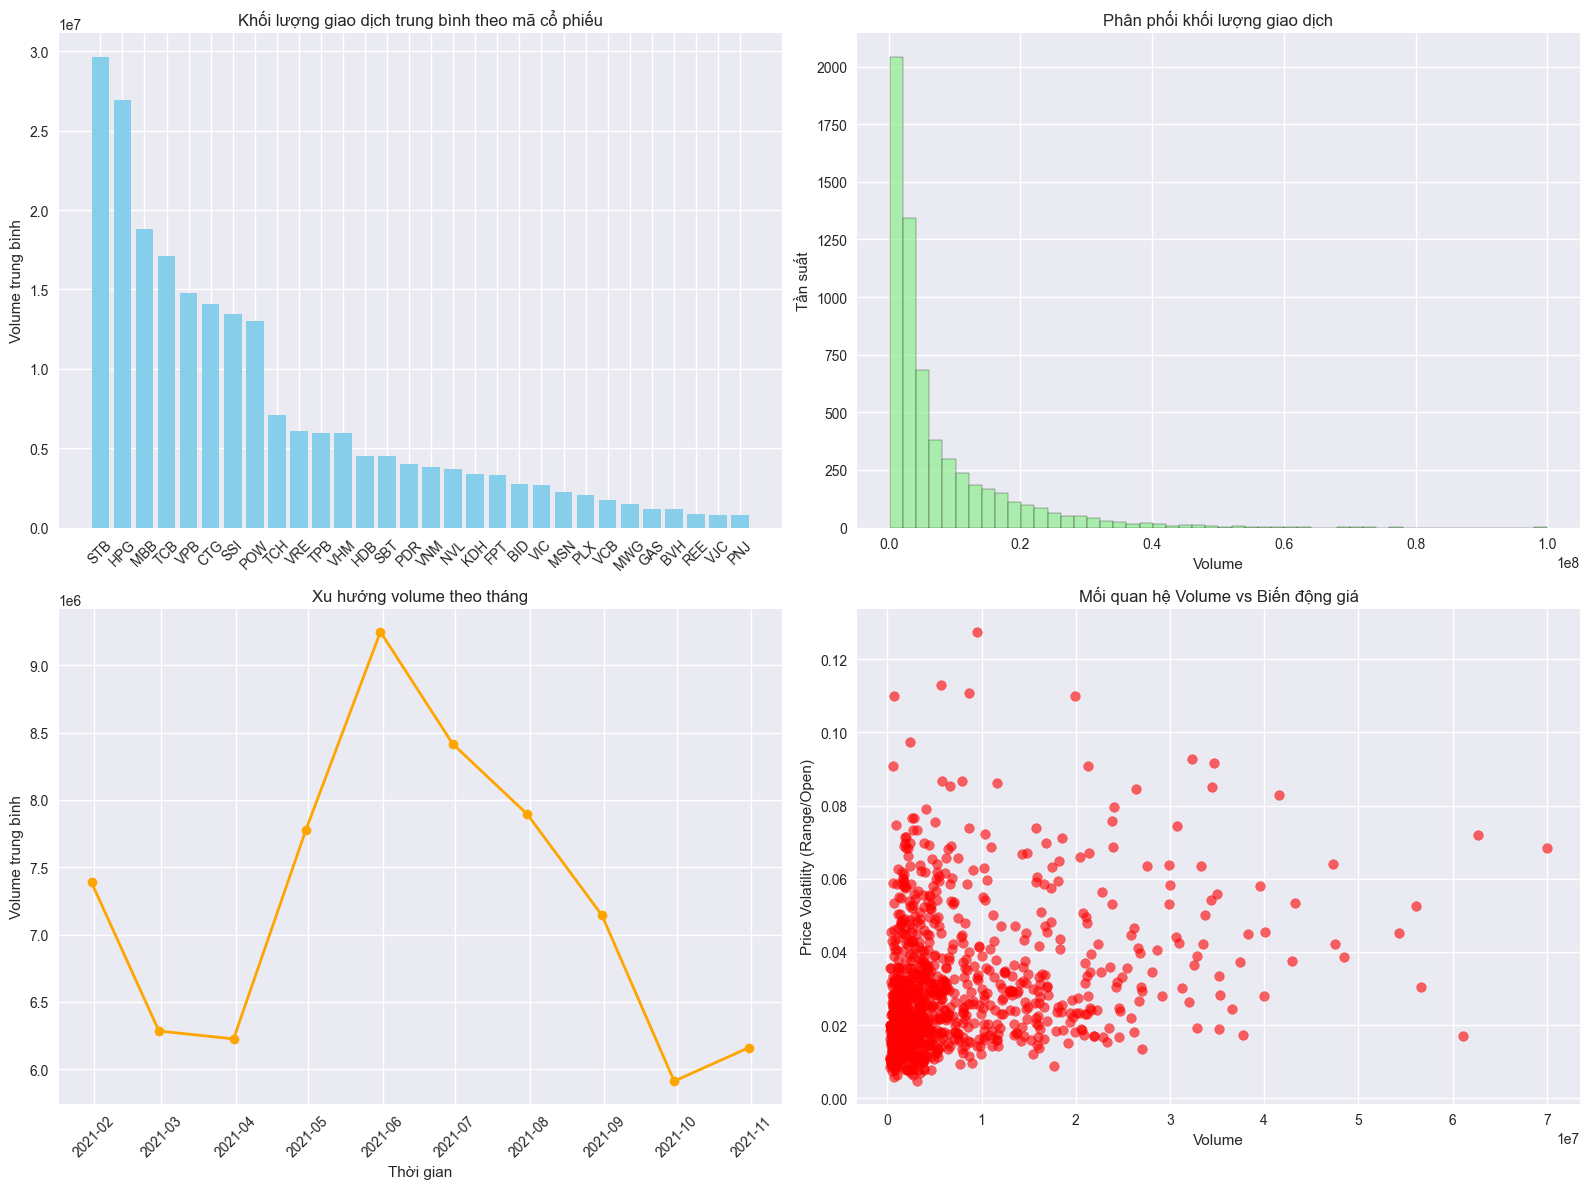


Correlation giữa Volume và Price Volatility: 0.2412


In [11]:
# Phân tích volume theo từng mã cổ phiếu
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Volume trung bình theo mã cổ phiếu
avg_volume = price_train_enhanced.groupby('symbol')['volume'].mean().sort_values(ascending=False)
axes[0, 0].bar(range(len(avg_volume)), avg_volume.values, color='skyblue')
axes[0, 0].set_title('Khối lượng giao dịch trung bình theo mã cổ phiếu', fontsize=12)
axes[0, 0].set_xticks(range(len(avg_volume)))
axes[0, 0].set_xticklabels(avg_volume.index, rotation=45)
axes[0, 0].set_ylabel('Volume trung bình')

# 2. Phân phối volume (histogram)
all_volumes = price_train_enhanced['volume'].values
axes[0, 1].hist(all_volumes, bins=50, alpha=0.7, color='lightgreen', edgecolor='black')
axes[0, 1].set_title('Phân phối khối lượng giao dịch', fontsize=12)
axes[0, 1].set_xlabel('Volume')
axes[0, 1].set_ylabel('Tần suất')

# 3. Volume theo thời gian (moving average)
monthly_volume = price_train_enhanced.set_index('date')['volume'].resample('M').mean()
axes[1, 0].plot(monthly_volume.index, monthly_volume.values, marker='o', linewidth=2, color='orange')
axes[1, 0].set_title('Xu hướng volume theo tháng', fontsize=12)
axes[1, 0].set_xlabel('Thời gian')
axes[1, 0].set_ylabel('Volume trung bình')
axes[1, 0].tick_params(axis='x', rotation=45)

# 4. Mối quan hệ giữa volume và biến động giá
price_train_enhanced['price_volatility'] = price_train_enhanced['price_range'] / price_train_enhanced['open']
sample_data = price_train_enhanced.sample(n=1000)  # Lấy mẫu để vẽ scatter plot
axes[1, 1].scatter(sample_data['volume'], sample_data['price_volatility'], alpha=0.6, color='red')
axes[1, 1].set_title('Mối quan hệ Volume vs Biến động giá', fontsize=12)
axes[1, 1].set_xlabel('Volume')
axes[1, 1].set_ylabel('Price Volatility (Range/Open)')

plt.tight_layout()
plt.show()

# Tính correlation giữa volume và price volatility
corr_vol_volatility = price_train_enhanced[['volume', 'price_volatility']].corr().iloc[0, 1]
print(f"\nCorrelation giữa Volume và Price Volatility: {corr_vol_volatility:.4f}")

### 3.4. Phân tích Daily Returns

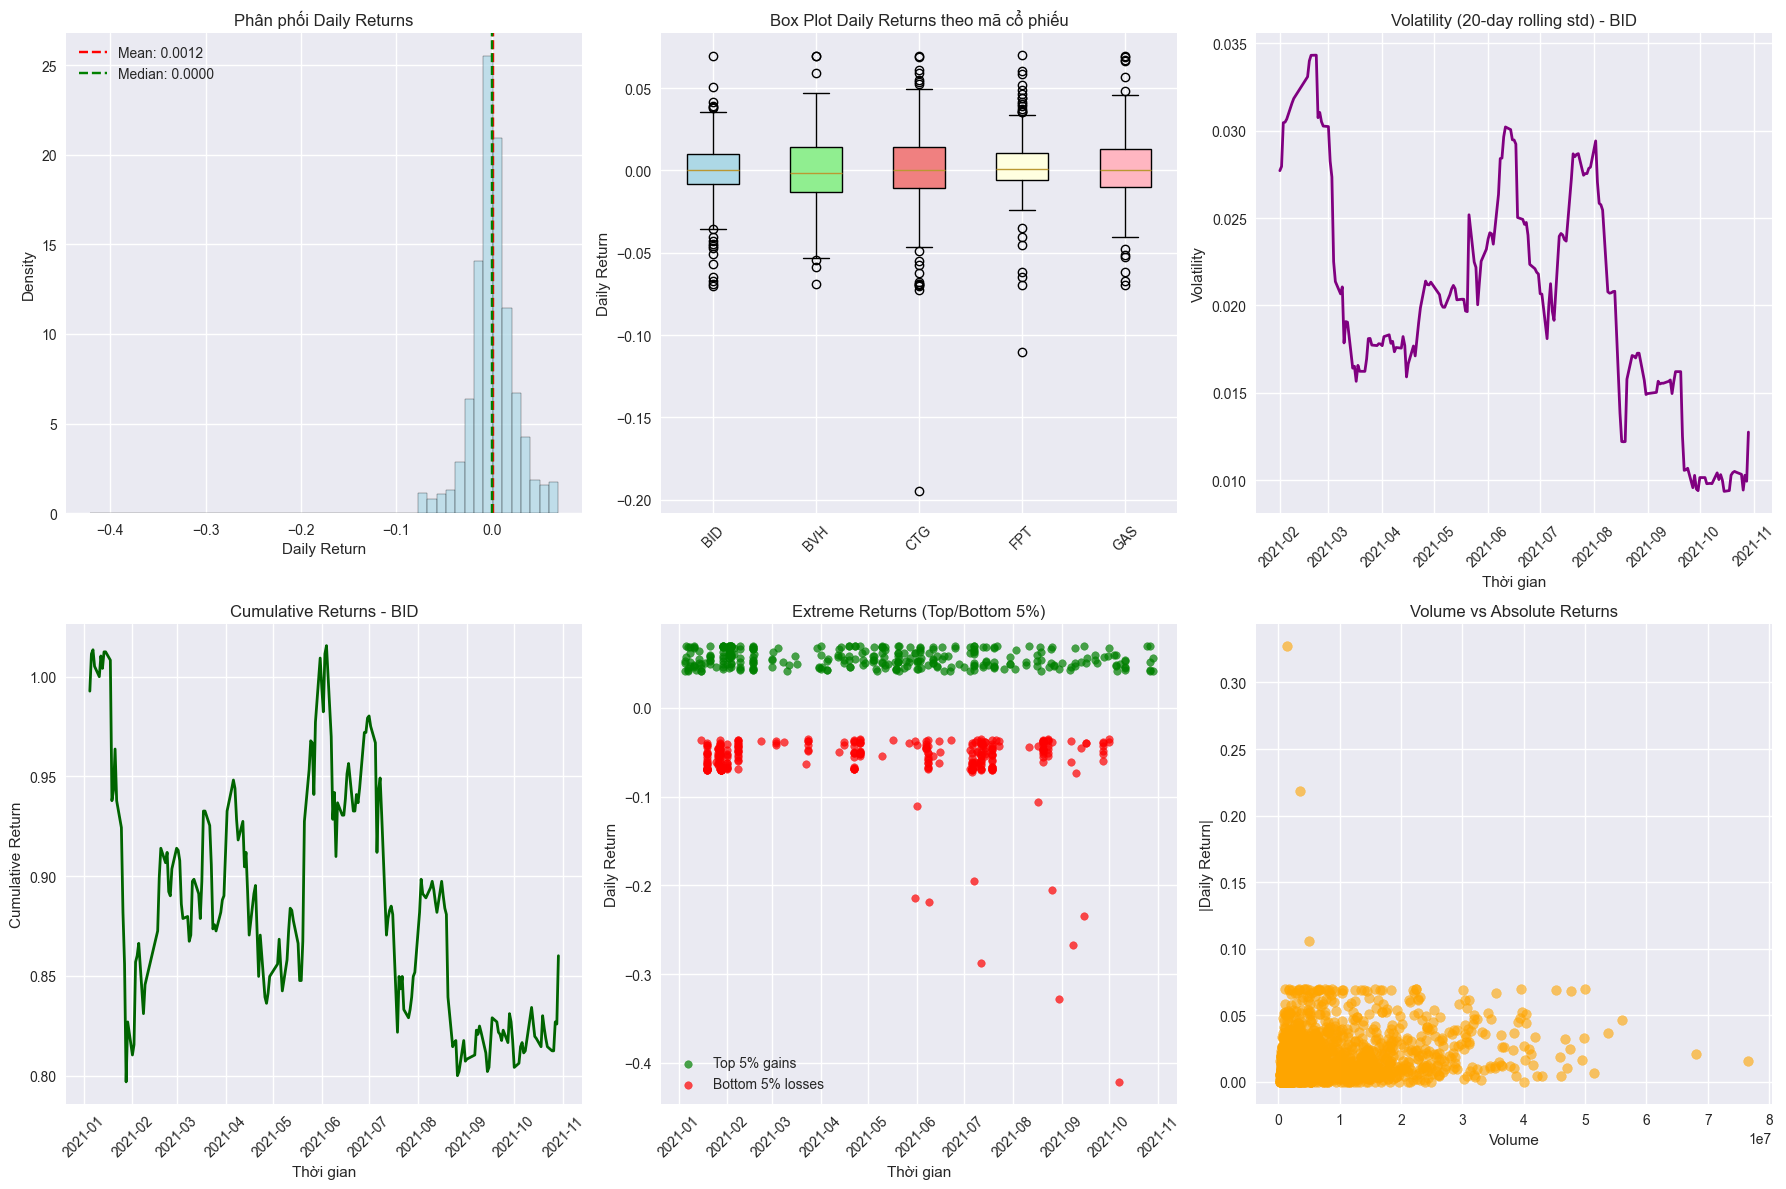


=== Thống kê Daily Returns ===
Mean: 0.001159
Std: 0.025165
Skewness: -2.0689
Kurtosis: 27.3366
Min: -0.421266
Max: 0.069966


In [12]:
# Phân tích daily returns
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Loại bỏ NaN values
returns_data = price_train_enhanced.dropna(subset=['daily_return'])

# 1. Histogram của daily returns
all_returns = returns_data['daily_return'].values
axes[0, 0].hist(all_returns, bins=50, alpha=0.7, color='lightblue', density=True, edgecolor='black')
axes[0, 0].axvline(np.mean(all_returns), color='red', linestyle='--', label=f'Mean: {np.mean(all_returns):.4f}')
axes[0, 0].axvline(np.median(all_returns), color='green', linestyle='--', label=f'Median: {np.median(all_returns):.4f}')
axes[0, 0].set_title('Phân phối Daily Returns', fontsize=12)
axes[0, 0].set_xlabel('Daily Return')
axes[0, 0].set_ylabel('Density')
axes[0, 0].legend()

# 2. Box plot daily returns theo từng mã cổ phiếu
returns_by_symbol = [returns_data[returns_data['symbol'] == symbol]['daily_return'].values for symbol in top_symbols]
bp = axes[0, 1].boxplot(returns_by_symbol, labels=top_symbols, patch_artist=True)
colors = ['lightblue', 'lightgreen', 'lightcoral', 'lightyellow', 'lightpink']
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
axes[0, 1].set_title('Box Plot Daily Returns theo mã cổ phiếu', fontsize=12)
axes[0, 1].set_ylabel('Daily Return')
axes[0, 1].tick_params(axis='x', rotation=45)

# 3. Volatility (rolling std) theo thời gian
main_symbol_data = returns_data[returns_data['symbol'] == main_symbol].copy()
main_symbol_data['rolling_volatility'] = main_symbol_data['daily_return'].rolling(window=20).std()
axes[0, 2].plot(main_symbol_data['date'], main_symbol_data['rolling_volatility'], color='purple', linewidth=2)
axes[0, 2].set_title(f'Volatility (20-day rolling std) - {main_symbol}', fontsize=12)
axes[0, 2].set_xlabel('Thời gian')
axes[0, 2].set_ylabel('Volatility')
axes[0, 2].tick_params(axis='x', rotation=45)

# 4. Cumulative returns
main_symbol_data['cumulative_return'] = (1 + main_symbol_data['daily_return']).cumprod()
axes[1, 0].plot(main_symbol_data['date'], main_symbol_data['cumulative_return'], color='darkgreen', linewidth=2)
axes[1, 0].set_title(f'Cumulative Returns - {main_symbol}', fontsize=12)
axes[1, 0].set_xlabel('Thời gian')
axes[1, 0].set_ylabel('Cumulative Return')
axes[1, 0].tick_params(axis='x', rotation=45)

# 5. Extreme returns (outliers)
extreme_positive = returns_data[returns_data['daily_return'] > returns_data['daily_return'].quantile(0.95)]
extreme_negative = returns_data[returns_data['daily_return'] < returns_data['daily_return'].quantile(0.05)]

axes[1, 1].scatter(extreme_positive['date'], extreme_positive['daily_return'], color='green', alpha=0.7, label='Top 5% gains', s=30)
axes[1, 1].scatter(extreme_negative['date'], extreme_negative['daily_return'], color='red', alpha=0.7, label='Bottom 5% losses', s=30)
axes[1, 1].set_title('Extreme Returns (Top/Bottom 5%)', fontsize=12)
axes[1, 1].set_xlabel('Thời gian')
axes[1, 1].set_ylabel('Daily Return')
axes[1, 1].legend()
axes[1, 1].tick_params(axis='x', rotation=45)

# 6. Returns vs Volume relationship
sample_returns = returns_data.sample(n=2000)
axes[1, 2].scatter(sample_returns['volume'], np.abs(sample_returns['daily_return']), alpha=0.6, color='orange')
axes[1, 2].set_title('Volume vs Absolute Returns', fontsize=12)
axes[1, 2].set_xlabel('Volume')
axes[1, 2].set_ylabel('|Daily Return|')

plt.tight_layout()
plt.show()

# Thống kê tóm tắt về returns
print("\n=== Thống kê Daily Returns ===")
print(f"Mean: {np.mean(all_returns):.6f}")
print(f"Std: {np.std(all_returns):.6f}")
print(f"Skewness: {pd.Series(all_returns).skew():.4f}")
print(f"Kurtosis: {pd.Series(all_returns).kurtosis():.4f}")
print(f"Min: {np.min(all_returns):.6f}")
print(f"Max: {np.max(all_returns):.6f}")

In [13]:
# Fix: Định nghĩa main_symbol
main_symbol = top_symbols[0]
print(f"Main symbol for analysis: {main_symbol}")

Main symbol for analysis: BID


### 3.5. Heatmap tương quan

### 3.5a. Phân tích dữ liệu Tài chính & Kinh doanh (Fundamental Analysis)

In [14]:
# Phân tích dữ liệu business và finance
print("=== Khám phá dữ liệu Business Train ===")
print(f"Business data shape: {business_train.shape}")
print(f"Business columns: {business_train.columns.tolist()}")
print(business_train.head())

print("\n=== Khám phá dữ liệu Finance Train ===")
print(f"Finance data shape: {finance_train.shape}")
print(f"Finance columns: {finance_train.columns.tolist()}")
print(finance_train.head())

# Kiểm tra các chỉ số tài chính quan trọng
print("\n=== Các chỉ số kinh doanh quan trọng ===")
print(business_train['index'].unique()[:10])  # Xem 10 chỉ số đầu

print("\n=== Các chỉ số tài chính quan trọng ===")
print(finance_train['index'].unique()[:10])  # Xem 10 chỉ số đầu

=== Khám phá dữ liệu Business Train ===
Business data shape: (823, 5)
Business columns: ['index', '2021-09', '2021-06', '2021-03', 'symbol']
                                       index       2021-09        2021-06  \
0  Chi phí lãi và các khoản chi phí tương tự  4.427778e+12  4548965000000   
1                         Thu nhập lãi thuần  3.313028e+12  3148209000000   
2              Thu nhập từ hoạt động dịch vụ  1.062325e+12  1478293000000   
3                  Chi phí hoạt động dịch vụ  4.724920e+11   541975000000   
4        Thu nhập thuần từ hoạt động dịch vụ  5.898330e+11   936318000000   

        2021-03 symbol  
0  4.646484e+12    STB  
1  3.008364e+12    STB  
2  1.335613e+12    STB  
3  4.982040e+11    STB  
4  8.374090e+11    STB  

=== Khám phá dữ liệu Finance Train ===
Finance data shape: (3421, 5)
Finance columns: ['index', '2021-06', '2021-03', '2021-09', 'symbol']
                                               index         2021-06  \
0                         Tiền mặt

In [15]:
# Chuyển đổi và merge dữ liệu fundamental
def process_fundamental_data(business_df, finance_df):
    """
    Xử lý dữ liệu tài chính và kinh doanh
    """
    # Chọn các chỉ số quan trọng từ business data
    important_business_metrics = [
        'Thu nhập lãi thuần',
        'Lợi nhuận gộp',  
        'Lợi nhuận thuần', 
        'Chi phí lãi và các khoản chi phí tương tự',
        'Thu nhập thuần từ hoạt động dịch vụ'
    ]
    
    # Chọn các chỉ số quan trọng từ finance data  
    important_finance_metrics = [
        'Tiền mặt, vàng bạc, đá quí',
        'Tổng tài sản',
        'Vốn chủ sở hữu',
        'Nợ phải trả'
    ]
    
    # Filter business data
    business_filtered = business_df[business_df['index'].isin(important_business_metrics)].copy()
    
    # Filter finance data
    finance_filtered = finance_df[finance_df['index'].isin(important_finance_metrics)].copy()
    
    # Melt data để có format dài
    business_melted = pd.melt(business_filtered, 
                             id_vars=['index', 'symbol'], 
                             value_vars=['2021-03', '2021-06', '2021-09'],
                             var_name='quarter', value_name='value')
    business_melted['metric_type'] = 'business'
    
    finance_melted = pd.melt(finance_filtered,
                            id_vars=['index', 'symbol'],
                            value_vars=['2021-03', '2021-06'],  # Finance có ít cột hơn
                            var_name='quarter', value_name='value')
    finance_melted['metric_type'] = 'finance'
    
    # Combine data
    fundamental_data = pd.concat([business_melted, finance_melted], ignore_index=True)
    fundamental_data['value'] = pd.to_numeric(fundamental_data['value'], errors='coerce')
    
    return fundamental_data

# Xử lý dữ liệu fundamental
fundamental_data = process_fundamental_data(business_train, finance_train)
print("=== Dữ liệu Fundamental sau xử lý ===")
print(f"Shape: {fundamental_data.shape}")
print(fundamental_data.head())

# Kiểm tra data availability
print("\n=== Symbols có trong fundamental data ===")
fund_symbols = fundamental_data['symbol'].unique()
print(f"Fundamental symbols: {fund_symbols}")
print(f"Price symbols: {symbols}")
print(f"Symbols chung: {set(fund_symbols).intersection(set(symbols))}")

=== Dữ liệu Fundamental sau xử lý ===
Shape: (282, 5)
                                       index symbol  quarter         value  \
0  Chi phí lãi và các khoản chi phí tương tự    STB  2021-03  4.646484e+12   
1                         Thu nhập lãi thuần    STB  2021-03  3.008364e+12   
2        Thu nhập thuần từ hoạt động dịch vụ    STB  2021-03  8.374090e+11   
3                              Lợi nhuận gộp    SSI  2021-03  8.099797e+11   
4  Chi phí lãi và các khoản chi phí tương tự    TCB  2021-03  2.027437e+12   

  metric_type  
0    business  
1    business  
2    business  
3    business  
4    business  

=== Symbols có trong fundamental data ===
Fundamental symbols: ['STB' 'SSI' 'TCB' 'VPB' 'HPG' 'MBB' 'POW' 'CTG' 'TCH' 'HDB' 'VHM' 'VRE'
 'VIC' 'SBT' 'NVL' 'PDR' 'BID' 'VNM' 'PLX' 'TPB' 'MWG' 'FPT' 'PNJ' 'MSN'
 'KDH' 'GAS' 'BVH' 'VJC' 'VCB' 'REE']
Price symbols: ['STB' 'SSI' 'TCB' 'VPB' 'HPG' 'MBB' 'POW' 'CTG' 'TCH' 'HDB' 'VHM' 'VRE'
 'VIC' 'SBT' 'NVL' 'PDR' 'BID' 'VNM' 'PLX' 'T

In [16]:
# Tạo dữ liệu tổng hợp cho phân tích fundamental vs technical
def create_fundamental_price_analysis():
    """
    Tạo dataset kết hợp giữa fundamental và price data
    """
    # Lấy dữ liệu giá theo quarter
    price_quarterly = price_train_enhanced.copy()
    price_quarterly['year'] = price_quarterly['date'].dt.year
    price_quarterly['month'] = price_quarterly['date'].dt.month
    
    # Map month to quarter
    def get_quarter(month):
        if month <= 3:
            return '2021-03'
        elif month <= 6:
            return '2021-06'
        else:
            return '2021-09'
    
    price_quarterly['quarter'] = price_quarterly['month'].apply(get_quarter)
    
    # Aggregate price data by quarter
    price_agg = price_quarterly.groupby(['symbol', 'quarter']).agg({
        'close': 'mean',
        'volume': 'mean',
        'daily_return': 'mean'
    }).reset_index()
    
    # Pivot fundamental data để có format wide
    fundamental_pivot = fundamental_data.pivot_table(
        index=['symbol', 'quarter'], 
        columns='index', 
        values='value', 
        aggfunc='first'
    ).reset_index()
    
    # Merge với price data
    merged_data = pd.merge(price_agg, fundamental_pivot, 
                          on=['symbol', 'quarter'], how='inner')
    
    return merged_data

# Tạo dataset merged
try:
    merged_fundamental_price = create_fundamental_price_analysis()
    print("=== Dữ liệu kết hợp Fundamental + Price ===")
    print(f"Shape: {merged_fundamental_price.shape}")
    print(f"Columns: {merged_fundamental_price.columns.tolist()}")
    print(merged_fundamental_price.head())
    
    has_fundamental_data = True
except Exception as e:
    print(f"Lỗi khi merge dữ liệu: {e}")
    print("Sẽ tiếp tục với các phân tích khác...")
    has_fundamental_data = False

=== Dữ liệu kết hợp Fundamental + Price ===
Shape: (85, 12)
Columns: ['symbol', 'quarter', 'close', 'volume', 'daily_return', 'Chi phí lãi và các khoản chi phí tương tự', 'Lợi nhuận gộp', 'Nợ phải trả', 'Thu nhập lãi thuần', 'Thu nhập thuần từ hoạt động dịch vụ', 'Tiền mặt, vàng bạc, đá quí', 'Vốn chủ sở hữu']
  symbol  quarter      close        volume  daily_return  \
0    BID  2021-03  43.902586  2.226700e+06     -0.001770   
1    BID  2021-06  44.269355  4.239300e+06      0.001780   
2    BID  2021-09  40.890588  1.973824e+06     -0.001363   
3    BVH  2021-03  61.593103  9.178914e+05     -0.001535   
4    BVH  2021-06  57.767742  1.126306e+06     -0.000129   

   Chi phí lãi và các khoản chi phí tương tự  Lợi nhuận gộp   Nợ phải trả  \
0                               1.322817e+13            NaN  1.476624e+15   
1                               1.324161e+13            NaN  1.557788e+15   
2                               1.378501e+13            NaN           NaN   
3                  

=== Correlation giữa các chỉ số tài chính và giá cổ phiếu ===
close                                        1.000000
Thu nhập lãi thuần                           0.596457
Tiền mặt, vàng bạc, đá quí                   0.551306
Thu nhập thuần từ hoạt động dịch vụ          0.449329
Lợi nhuận gộp                                0.408643
Vốn chủ sở hữu                               0.251565
Chi phí lãi và các khoản chi phí tương tự    0.243838
daily_return                                 0.005260
Nợ phải trả                                 -0.079425
volume                                      -0.463921
Name: close, dtype: float64


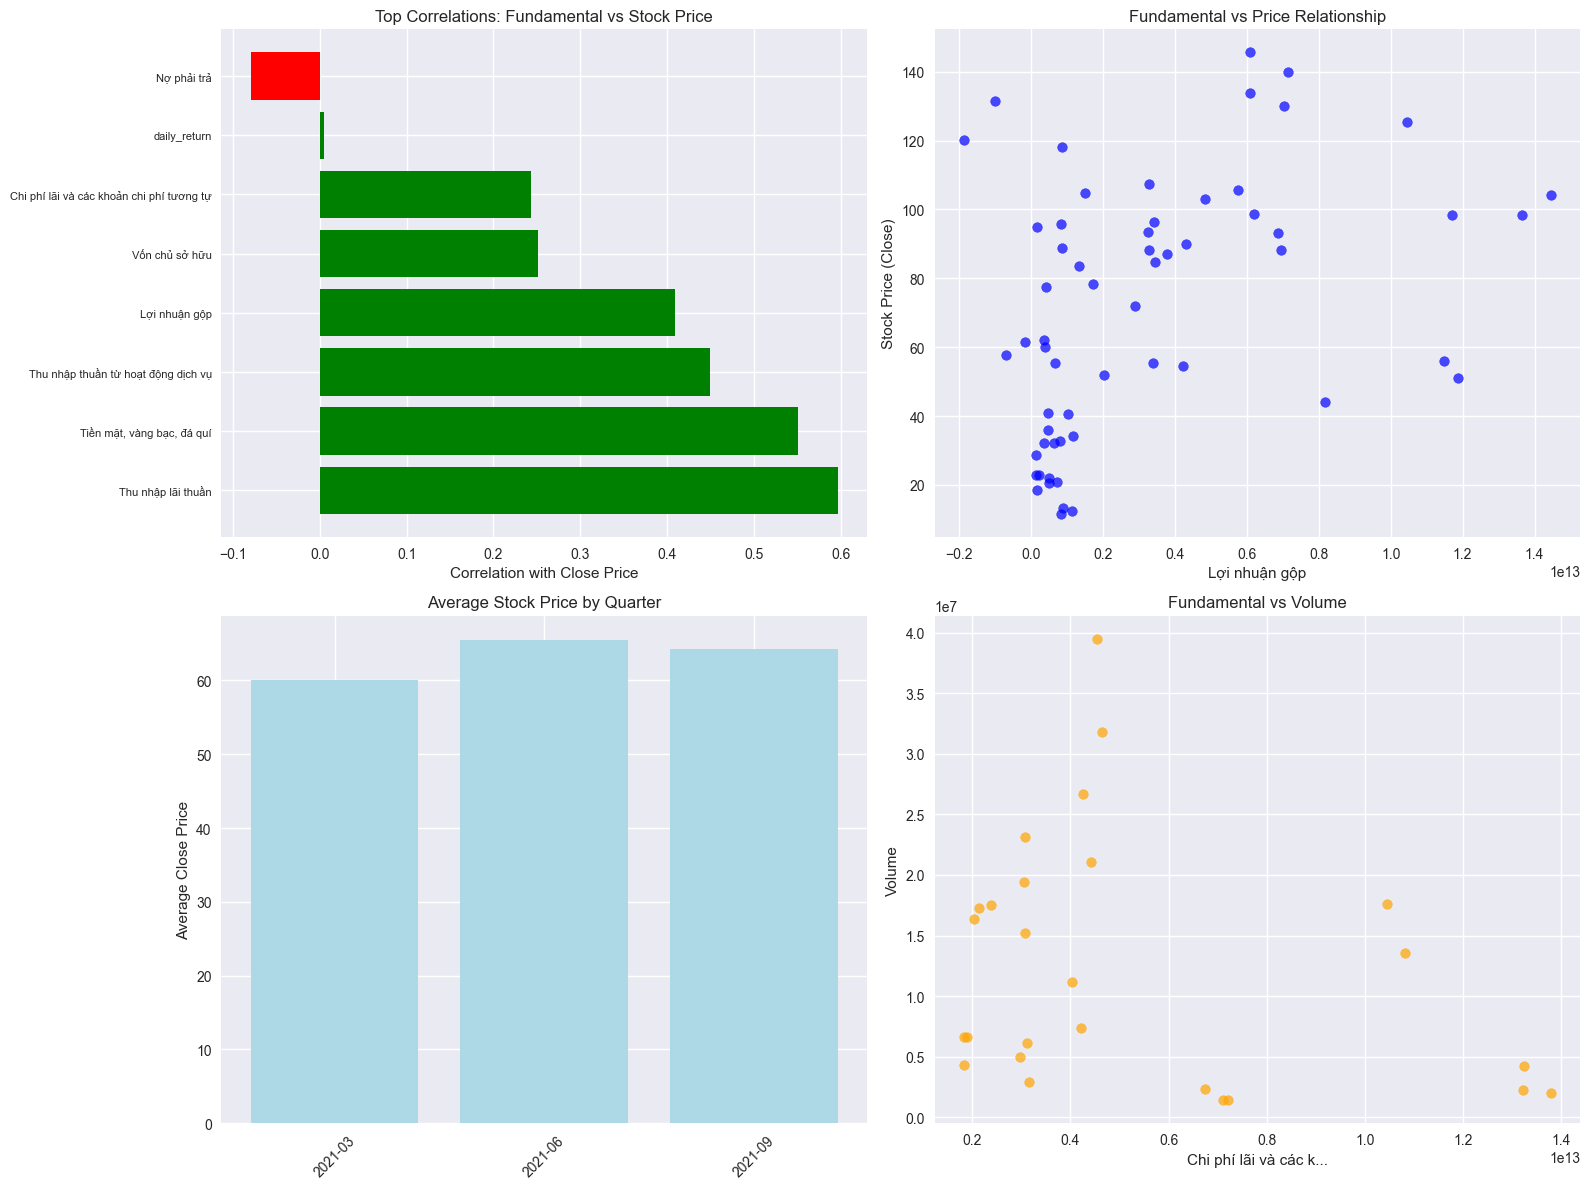

In [17]:
# Visualize mối quan hệ giữa fundamental và price
if has_fundamental_data and len(merged_fundamental_price) > 0:
    # Lọc columns số để tính correlation
    numeric_cols = merged_fundamental_price.select_dtypes(include=[np.number]).columns
    corr_with_price = merged_fundamental_price[numeric_cols].corr()['close'].sort_values(ascending=False)
    
    print("=== Correlation giữa các chỉ số tài chính và giá cổ phiếu ===")
    print(corr_with_price.head(10))
    
    # Visualize top correlations
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # 1. Bar chart của top correlations
    top_corr = corr_with_price.drop('close').head(8)  # Loại bỏ close vs close
    axes[0, 0].barh(range(len(top_corr)), top_corr.values, 
                    color=['green' if x > 0 else 'red' for x in top_corr.values])
    axes[0, 0].set_title('Top Correlations: Fundamental vs Stock Price')
    axes[0, 0].set_yticks(range(len(top_corr)))
    axes[0, 0].set_yticklabels(top_corr.index, fontsize=8)
    axes[0, 0].set_xlabel('Correlation with Close Price')
    
    # 2. Scatter plot - Lợi nhuận vs Giá (nếu có)
    profit_cols = [col for col in merged_fundamental_price.columns if 'lợi nhuận' in col.lower() or 'thu nhập' in col.lower()]
    if profit_cols:
        profit_col = profit_cols[0]
        clean_data = merged_fundamental_price.dropna(subset=[profit_col, 'close'])
        if len(clean_data) > 0:
            axes[0, 1].scatter(clean_data[profit_col], clean_data['close'], alpha=0.7, color='blue')
            axes[0, 1].set_xlabel(profit_col[:20] + '...' if len(profit_col) > 20 else profit_col)
            axes[0, 1].set_ylabel('Stock Price (Close)')
            axes[0, 1].set_title('Fundamental vs Price Relationship')
    
    # 3. Trend theo quarter
    if 'quarter' in merged_fundamental_price.columns:
        quarter_analysis = merged_fundamental_price.groupby('quarter')['close'].mean()
        axes[1, 0].bar(quarter_analysis.index, quarter_analysis.values, color='lightblue')
        axes[1, 0].set_title('Average Stock Price by Quarter')
        axes[1, 0].set_ylabel('Average Close Price')
        axes[1, 0].tick_params(axis='x', rotation=45)
    
    # 4. Volume vs Fundamental
    if len(numeric_cols) > 3:
        fund_col = [col for col in numeric_cols if col not in ['close', 'volume', 'daily_return']][0]
        clean_data_vol = merged_fundamental_price.dropna(subset=[fund_col, 'volume'])
        if len(clean_data_vol) > 0:
            axes[1, 1].scatter(clean_data_vol[fund_col], clean_data_vol['volume'], alpha=0.7, color='orange')
            axes[1, 1].set_xlabel(fund_col[:20] + '...' if len(fund_col) > 20 else fund_col)
            axes[1, 1].set_ylabel('Volume')
            axes[1, 1].set_title('Fundamental vs Volume')
    
    plt.tight_layout()
    plt.show()
    
else:
    print("Không thể phân tích fundamental data do vấn đề với dữ liệu")
    
    # Thay vào đó, hiển thị thống kê cơ bản về business và finance data
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Business metrics distribution
    if len(business_train) > 0:
        business_sample = business_train.head(10)  # Lấy 10 chỉ số đầu
        axes[0].barh(range(len(business_sample)), 
                     pd.to_numeric(business_sample.iloc[:, 1], errors='coerce').fillna(0))
        axes[0].set_title('Top Business Metrics (Sample)')
        axes[0].set_yticks(range(len(business_sample)))
        axes[0].set_yticklabels(business_sample['index'], fontsize=8)
    
    # Finance metrics distribution  
    if len(finance_train) > 0:
        finance_sample = finance_train.head(10)  # Lấy 10 chỉ số đầu
        axes[1].barh(range(len(finance_sample)), 
                     pd.to_numeric(finance_sample.iloc[:, 1], errors='coerce').fillna(0))
        axes[1].set_title('Top Finance Metrics (Sample)')
        axes[1].set_yticks(range(len(finance_sample)))
        axes[1].set_yticklabels(finance_sample['index'], fontsize=8)
    
    plt.tight_layout()
    plt.show()

### 3.5b. Phân tích tự tương quan (Autocorrelation - ACF/PACF)

Phân tích autocorrelation cho mã: STB
Dữ liệu STB: 204 records
Using 50 lags for analysis


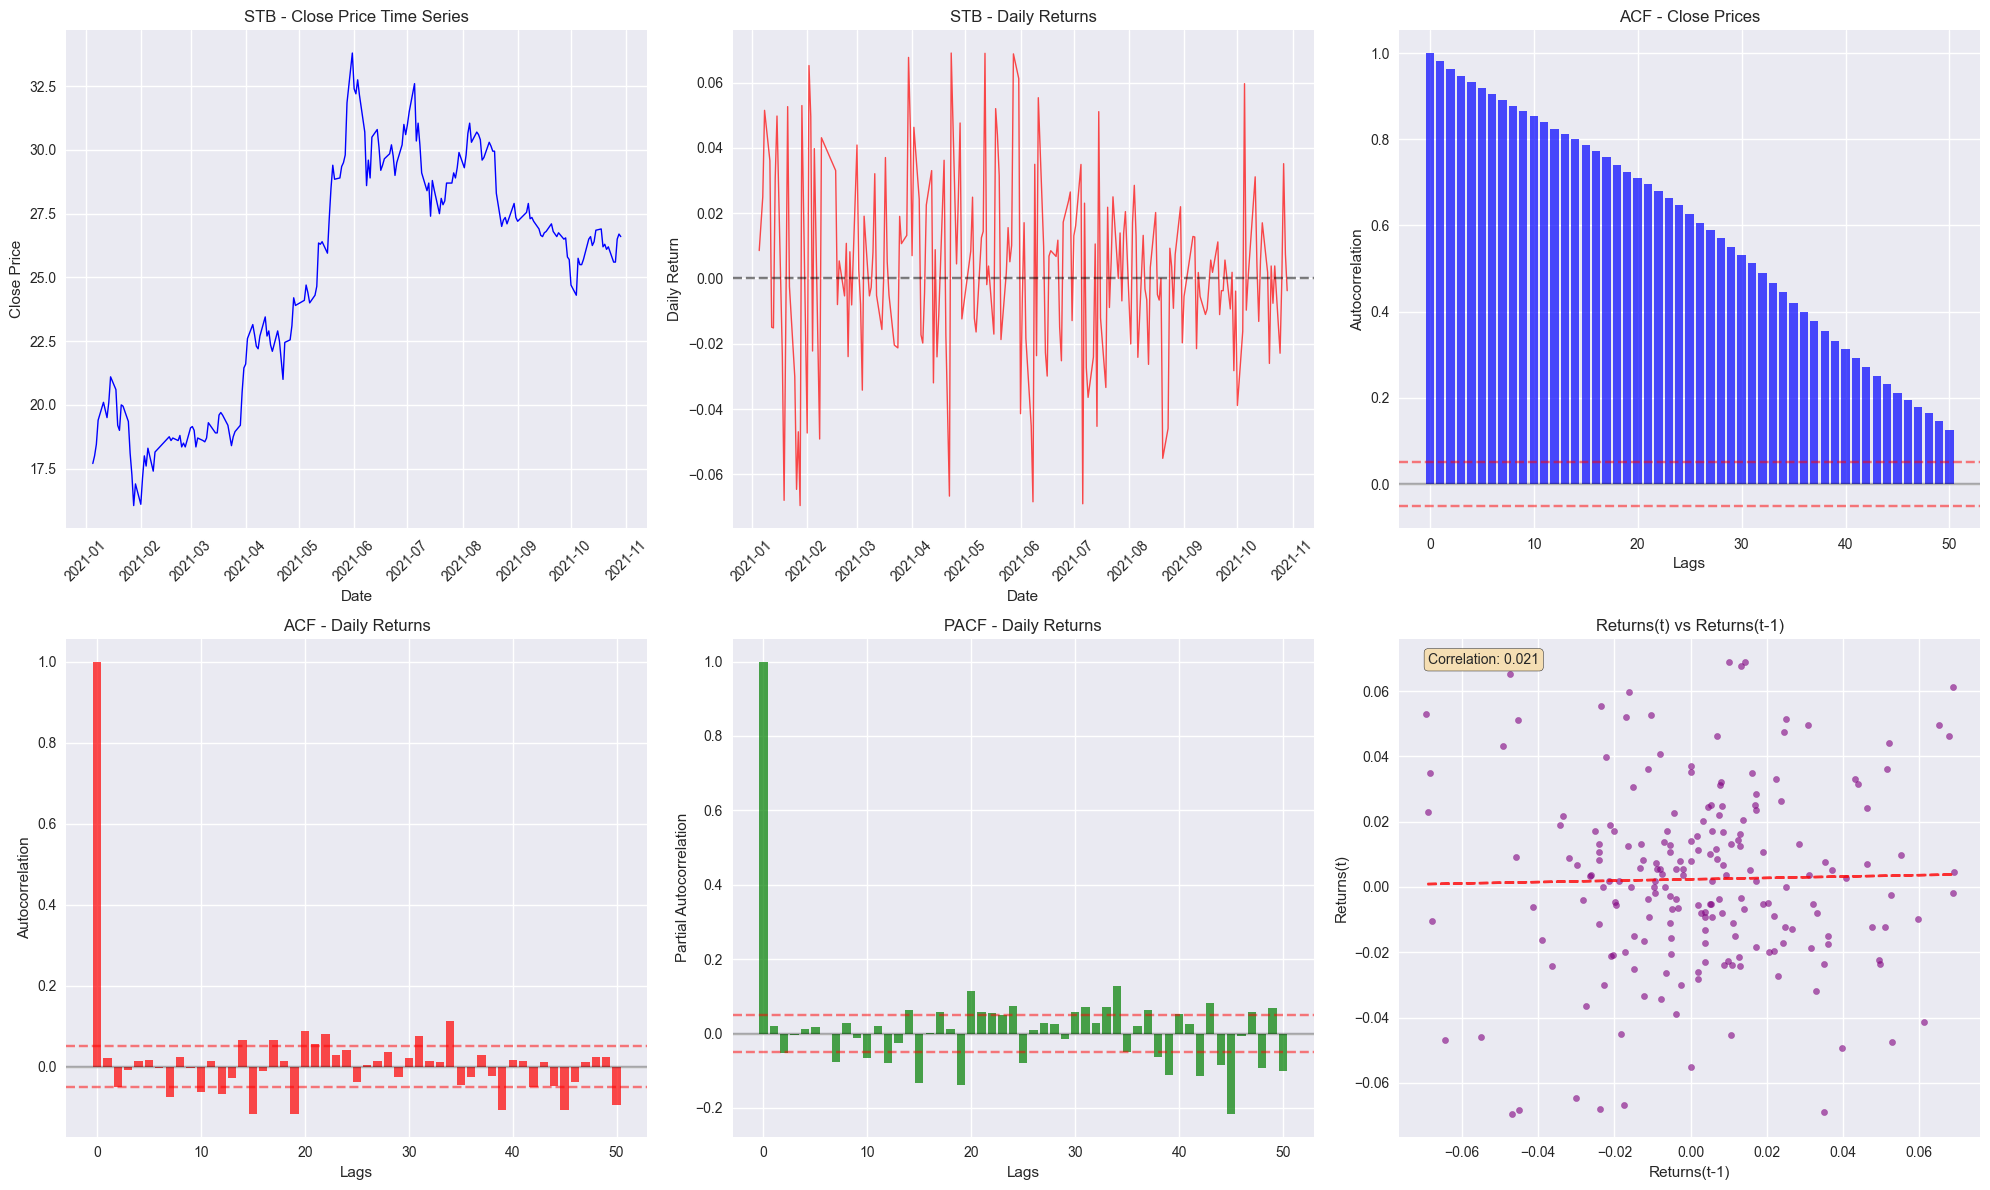


=== Autocorrelation Analysis Summary ===
Symbol: STB
Data points: 204
ACF at lag 1 (returns): 0.0211
ACF at lag 5 (returns): 0.0172
PACF at lag 1 (returns): 0.0212
Lag-1 correlation: 0.0211

=== Insights ===
✓ Returns show weak autocorrelation (good for random walk hypothesis)
✓ Prices show strong positive autocorrelation (expected for price series)


In [18]:
# Autocorrelation Analysis - Time Series Correlation Patterns
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Chọn mã cổ phiếu có volume cao nhất để phân tích
volume_by_symbol = price_train.groupby('symbol')['volume'].mean().sort_values(ascending=False)
main_symbol = volume_by_symbol.index[0]  # Lấy mã có volume cao nhất
print(f"Phân tích autocorrelation cho mã: {main_symbol}")

# Lấy dữ liệu cho mã chính
main_data = price_train_enhanced[price_train_enhanced['symbol'] == main_symbol].copy()
main_data = main_data.dropna(subset=['daily_return']).sort_values('date')

print(f"Dữ liệu {main_symbol}: {len(main_data)} records")

# Tính lag correlation 
lags = min(50, len(main_data)//4)  # Tối đa 50 lags hoặc 1/4 độ dài data
price_series = main_data['close'].values
returns_series = main_data['daily_return'].values

print(f"Using {lags} lags for analysis")

# Create comprehensive correlation analysis
fig, axes = plt.subplots(2, 3, figsize=(20, 12))

# 1. Price time series
axes[0, 0].plot(main_data['date'], main_data['close'], color='blue', linewidth=1)
axes[0, 0].set_title(f'{main_symbol} - Close Price Time Series')
axes[0, 0].set_xlabel('Date')
axes[0, 0].set_ylabel('Close Price')
axes[0, 0].tick_params(axis='x', rotation=45)

# 2. Returns time series
axes[0, 1].plot(main_data['date'], returns_series, color='red', linewidth=1, alpha=0.7)
axes[0, 1].axhline(y=0, color='black', linestyle='--', alpha=0.5)
axes[0, 1].set_title(f'{main_symbol} - Daily Returns')
axes[0, 1].set_xlabel('Date') 
axes[0, 1].set_ylabel('Daily Return')
axes[0, 1].tick_params(axis='x', rotation=45)

# 3. ACF của giá
try:
    acf_values_price = acf(price_series, nlags=lags)
    axes[0, 2].bar(range(len(acf_values_price)), acf_values_price, alpha=0.7, color='blue')
    axes[0, 2].set_title('ACF - Close Prices')
    axes[0, 2].set_xlabel('Lags')
    axes[0, 2].set_ylabel('Autocorrelation')
    axes[0, 2].axhline(y=0, color='black', linestyle='-', alpha=0.3)
    axes[0, 2].axhline(y=0.05, color='red', linestyle='--', alpha=0.5)
    axes[0, 2].axhline(y=-0.05, color='red', linestyle='--', alpha=0.5)
except:
    axes[0, 2].text(0.5, 0.5, 'Error in ACF calculation', transform=axes[0, 2].transAxes)

# 4. ACF của returns
try:
    acf_values_returns = acf(returns_series, nlags=lags)
    axes[1, 0].bar(range(len(acf_values_returns)), acf_values_returns, alpha=0.7, color='red')
    axes[1, 0].set_title('ACF - Daily Returns')
    axes[1, 0].set_xlabel('Lags')
    axes[1, 0].set_ylabel('Autocorrelation')
    axes[1, 0].axhline(y=0, color='black', linestyle='-', alpha=0.3)
    axes[1, 0].axhline(y=0.05, color='red', linestyle='--', alpha=0.5)
    axes[1, 0].axhline(y=-0.05, color='red', linestyle='--', alpha=0.5)
except:
    axes[1, 0].text(0.5, 0.5, 'Error in ACF calculation', transform=axes[1, 0].transAxes)

# 5. PACF của returns
try:
    pacf_values_returns = pacf(returns_series, nlags=lags)
    axes[1, 1].bar(range(len(pacf_values_returns)), pacf_values_returns, alpha=0.7, color='green')
    axes[1, 1].set_title('PACF - Daily Returns')
    axes[1, 1].set_xlabel('Lags')
    axes[1, 1].set_ylabel('Partial Autocorrelation')
    axes[1, 1].axhline(y=0, color='black', linestyle='-', alpha=0.3)
    axes[1, 1].axhline(y=0.05, color='red', linestyle='--', alpha=0.5)
    axes[1, 1].axhline(y=-0.05, color='red', linestyle='--', alpha=0.5)
except:
    axes[1, 1].text(0.5, 0.5, 'Error in PACF calculation', transform=axes[1, 1].transAxes)

# 6. Lag scatter plot (returns vs lagged returns)
if len(returns_series) > 1:
    returns_lag1 = returns_series[:-1]  # t-1
    returns_current = returns_series[1:]  # t
    axes[1, 2].scatter(returns_lag1, returns_current, alpha=0.6, s=20, color='purple')
    axes[1, 2].set_title('Returns(t) vs Returns(t-1)')
    axes[1, 2].set_xlabel('Returns(t-1)')
    axes[1, 2].set_ylabel('Returns(t)')
    
    # Add correlation coefficient
    correlation = np.corrcoef(returns_lag1, returns_current)[0,1]
    axes[1, 2].text(0.05, 0.95, f'Correlation: {correlation:.3f}', 
                   transform=axes[1, 2].transAxes, bbox=dict(boxstyle="round", facecolor="wheat"))
    
    # Add regression line
    z = np.polyfit(returns_lag1, returns_current, 1)
    p = np.poly1d(z)
    axes[1, 2].plot(returns_lag1, p(returns_lag1), "r--", alpha=0.8)

plt.tight_layout()
plt.show()

# Statistical summary
print("\n=== Autocorrelation Analysis Summary ===")
print(f"Symbol: {main_symbol}")
print(f"Data points: {len(main_data)}")

if 'acf_values_returns' in locals():
    print(f"ACF at lag 1 (returns): {acf_values_returns[1]:.4f}")
    print(f"ACF at lag 5 (returns): {acf_values_returns[5]:.4f}" if len(acf_values_returns) > 5 else "")
    
if 'pacf_values_returns' in locals():
    print(f"PACF at lag 1 (returns): {pacf_values_returns[1]:.4f}")
    
if 'correlation' in locals():
    print(f"Lag-1 correlation: {correlation:.4f}")

# Interpretation
print("\n=== Insights ===")
if 'acf_values_returns' in locals() and len(acf_values_returns) > 1:
    if abs(acf_values_returns[1]) < 0.05:
        print("✓ Returns show weak autocorrelation (good for random walk hypothesis)")
    else:
        print("! Returns show significant autocorrelation (potential for prediction)")
        
if 'acf_values_price' in locals() and len(acf_values_price) > 1:
    if acf_values_price[1] > 0.9:
        print("✓ Prices show strong positive autocorrelation (expected for price series)")
    else:
        print("! Price autocorrelation lower than expected")

### 3.5c. Trực quan hóa đường xu hướng (Moving Averages)

In [19]:
# Moving Averages Analysis
def calculate_moving_averages(data, symbol):
    """Calculate various moving averages for a stock symbol"""
    symbol_data = data[data['symbol'] == symbol].copy()
    symbol_data = symbol_data.sort_values('date')
    
    # Simple Moving Averages
    symbol_data['MA5'] = symbol_data['close'].rolling(window=5).mean()
    symbol_data['MA20'] = symbol_data['close'].rolling(window=20).mean()
    symbol_data['MA50'] = symbol_data['close'].rolling(window=50).mean()
    
    # Exponential Moving Averages
    symbol_data['EMA12'] = symbol_data['close'].ewm(span=12).mean()
    symbol_data['EMA26'] = symbol_data['close'].ewm(span=26).mean()
    
    # MACD
    symbol_data['MACD'] = symbol_data['EMA12'] - symbol_data['EMA26']
    symbol_data['MACD_signal'] = symbol_data['MACD'].ewm(span=9).mean()
    symbol_data['MACD_histogram'] = symbol_data['MACD'] - symbol_data['MACD_signal']
    
    return symbol_data

# Chọn các mã có volume cao để phân tích
volume_by_symbol = price_train.groupby('symbol')['volume'].mean().sort_values(ascending=False)
top_symbols = volume_by_symbol.index[:4].tolist()  # Top 4 symbols by volume

print("=== Tính toán Moving Averages cho các mã chính ===")
print(f"Top symbols by volume: {top_symbols}")

# Calculate MA for each symbol
ma_data = {}
for symbol in top_symbols:
    ma_data[symbol] = calculate_moving_averages(price_train, symbol)
    print(f"Completed MA calculation for {symbol}: {len(ma_data[symbol])} records")

print(f"\\nMoving averages calculated for {len(ma_data)} symbols")

=== Tính toán Moving Averages cho các mã chính ===
Top symbols by volume: ['STB', 'HPG', 'MBB', 'TCB']
Completed MA calculation for STB: 205 records
Completed MA calculation for HPG: 205 records
Completed MA calculation for MBB: 205 records
Completed MA calculation for TCB: 205 records
\nMoving averages calculated for 4 symbols


In [20]:
# Moving Averages Analysis
def calculate_moving_averages(data, symbol):
    """Calculate various moving averages for a stock symbol"""
    symbol_data = data[data['symbol'] == symbol].copy()
    symbol_data = symbol_data.sort_values('date')
    
    # Simple Moving Averages
    symbol_data['MA5'] = symbol_data['close'].rolling(window=5).mean()
    symbol_data['MA20'] = symbol_data['close'].rolling(window=20).mean()
    symbol_data['MA50'] = symbol_data['close'].rolling(window=50).mean()
    
    # Exponential Moving Averages
    symbol_data['EMA12'] = symbol_data['close'].ewm(span=12).mean()
    symbol_data['EMA26'] = symbol_data['close'].ewm(span=26).mean()
    
    # MACD
    symbol_data['MACD'] = symbol_data['EMA12'] - symbol_data['EMA26']
    symbol_data['MACD_signal'] = symbol_data['MACD'].ewm(span=9).mean()
    symbol_data['MACD_histogram'] = symbol_data['MACD'] - symbol_data['MACD_signal']
    
    return symbol_data

# Chọn các mã có volume cao để phân tích
volume_by_symbol = price_train.groupby('symbol')['volume'].mean().sort_values(ascending=False)
top_symbols = volume_by_symbol.index[:4].tolist()  # Top 4 symbols by volume

print("=== Tính toán Moving Averages cho các mã chính ===")
print(f"Top symbols by volume: {top_symbols}")

# Calculate MA for each symbol
ma_data = {}
for symbol in top_symbols:
    ma_data[symbol] = calculate_moving_averages(price_train, symbol)
    print(f"Completed MA calculation for {symbol}: {len(ma_data[symbol])} records")

print(f"\\nMoving averages calculated for {len(ma_data)} symbols")

=== Tính toán Moving Averages cho các mã chính ===
Top symbols by volume: ['STB', 'HPG', 'MBB', 'TCB']
Completed MA calculation for STB: 205 records
Completed MA calculation for HPG: 205 records
Completed MA calculation for MBB: 205 records
Completed MA calculation for TCB: 205 records
\nMoving averages calculated for 4 symbols


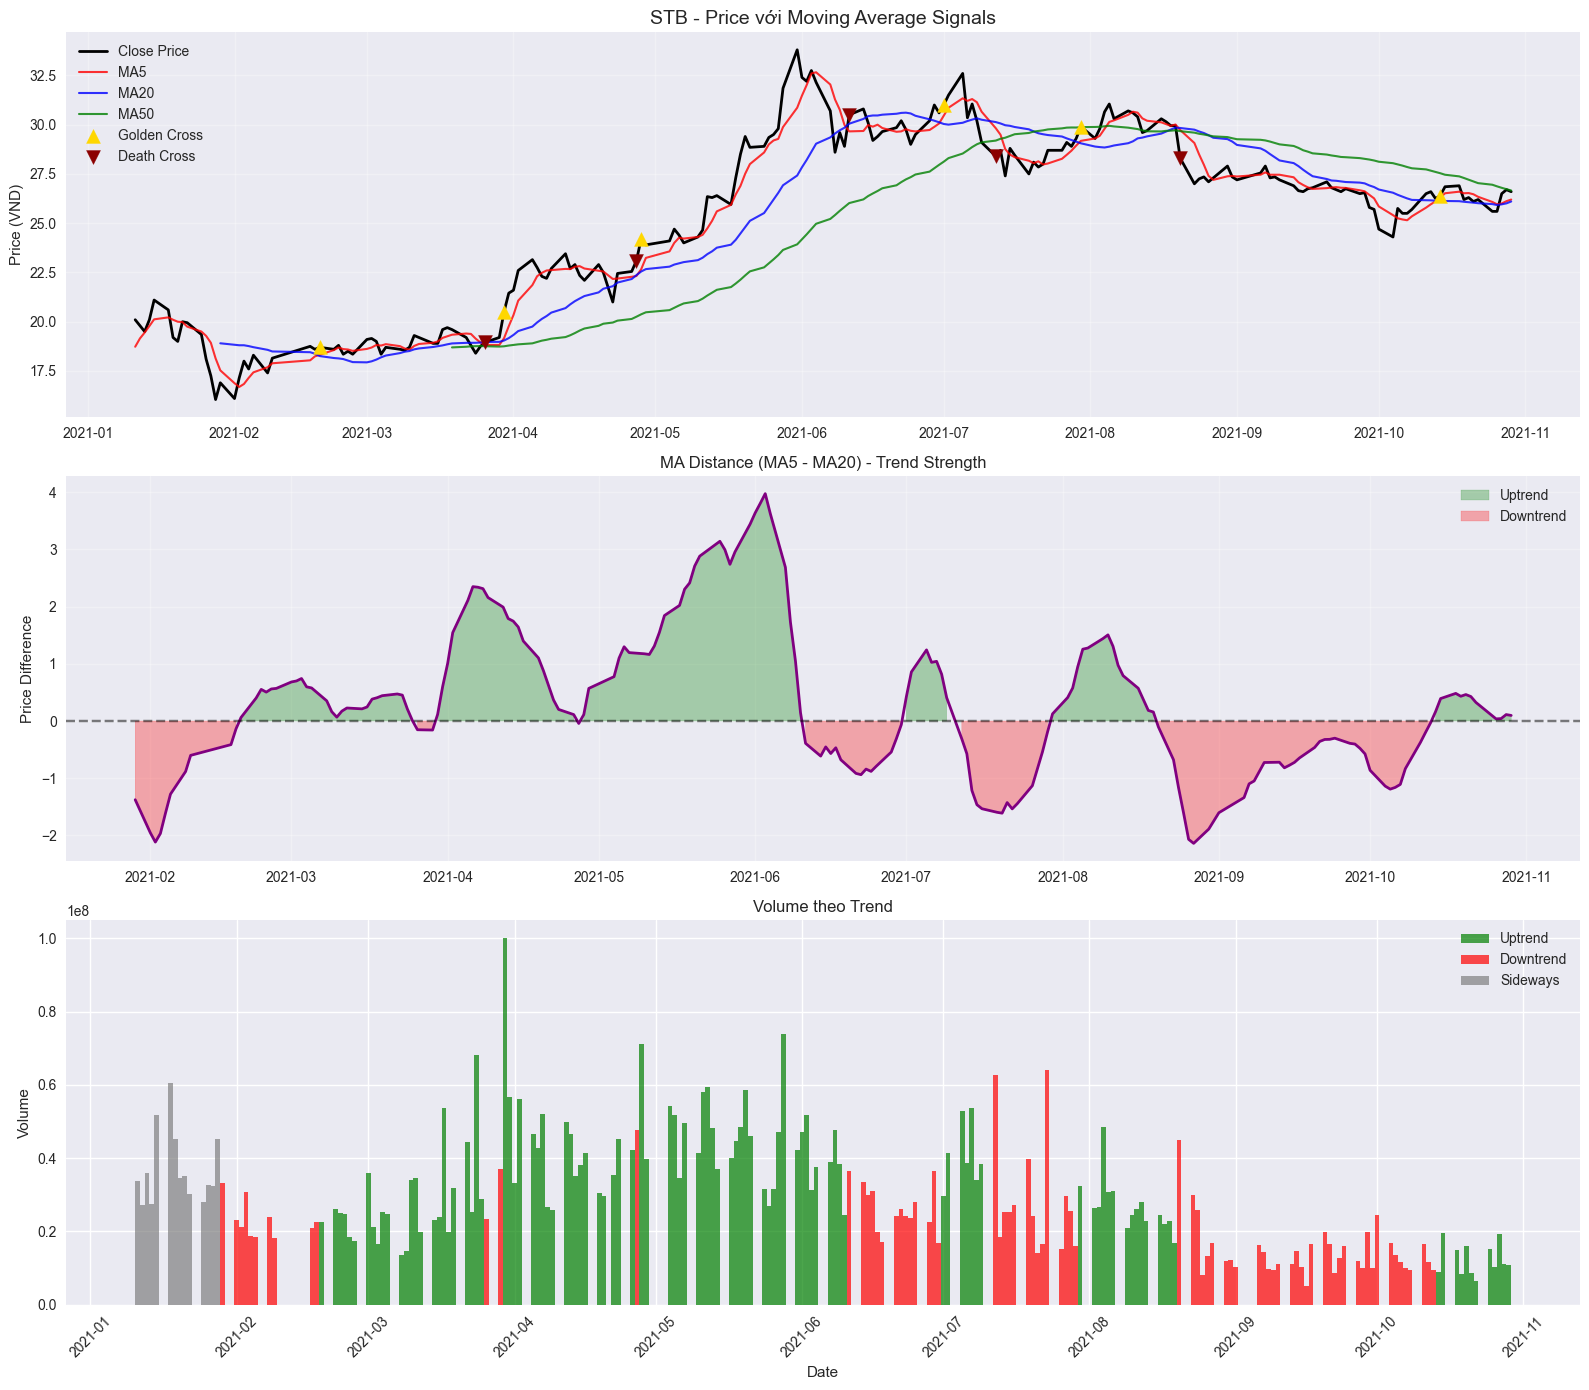


=== Thống kê Trend cho STB (200 ngày gần nhất) ===
Uptrend: 108 ngày (54.0%)
Downtrend: 78 ngày (39.0%)
Sideways: 14 ngày (7.0%)

Tín hiệu trong 200 ngày:
Golden Cross: 6 lần
Death Cross: 5 lần
Average MA Distance: 0.27 (>0: bullish, <0: bearish)


In [21]:
# Phân tích chi tiết xu hướng với MA crossovers
def analyze_trend_signals(df, symbol):
    """
    Phân tích tín hiệu xu hướng từ MA crossovers
    """
    symbol_data = calculate_moving_averages(df, symbol)
    
    # Xác định tín hiệu
    symbol_data['Golden_Cross'] = (symbol_data['MA5'] > symbol_data['MA20']) & \
                                  (symbol_data['MA5'].shift(1) <= symbol_data['MA20'].shift(1))
    
    symbol_data['Death_Cross'] = (symbol_data['MA5'] < symbol_data['MA20']) & \
                                 (symbol_data['MA5'].shift(1) >= symbol_data['MA20'].shift(1))
    
    # Trend classification
    symbol_data['Trend'] = 'Sideways'
    symbol_data.loc[symbol_data['MA5'] > symbol_data['MA20'], 'Trend'] = 'Uptrend'
    symbol_data.loc[symbol_data['MA5'] < symbol_data['MA20'], 'Trend'] = 'Downtrend'
    
    return symbol_data

# Áp dụng analysis cho main symbol
main_symbol_trend = analyze_trend_signals(price_train_enhanced, main_symbol)

# Visualization với matplotlib cho detailed analysis
fig, axes = plt.subplots(3, 1, figsize=(16, 14))

# Lấy 200 ngày gần nhất
recent_trend_data = main_symbol_trend.tail(200)

# 1. Price với MA và signals
axes[0].plot(recent_trend_data['date'], recent_trend_data['close'], 
            color='black', linewidth=2, label='Close Price')
axes[0].plot(recent_trend_data['date'], recent_trend_data['MA5'], 
            color='red', linewidth=1.5, label='MA5', alpha=0.8)
axes[0].plot(recent_trend_data['date'], recent_trend_data['MA20'], 
            color='blue', linewidth=1.5, label='MA20', alpha=0.8)
axes[0].plot(recent_trend_data['date'], recent_trend_data['MA50'], 
            color='green', linewidth=1.5, label='MA50', alpha=0.8)

# Highlight Golden Cross và Death Cross
golden_crosses = recent_trend_data[recent_trend_data['Golden_Cross']]
death_crosses = recent_trend_data[recent_trend_data['Death_Cross']]

axes[0].scatter(golden_crosses['date'], golden_crosses['close'], 
               color='gold', s=100, marker='^', label='Golden Cross', zorder=5)
axes[0].scatter(death_crosses['date'], death_crosses['close'], 
               color='darkred', s=100, marker='v', label='Death Cross', zorder=5)

axes[0].set_title(f'{main_symbol} - Price với Moving Average Signals', fontsize=14)
axes[0].set_ylabel('Price (VND)')
axes[0].legend(loc='upper left')
axes[0].grid(True, alpha=0.3)

# 2. MA distance (MA5 - MA20 để đo strength của trend)
recent_trend_data['MA_Distance'] = recent_trend_data['MA5'] - recent_trend_data['MA20']
axes[1].plot(recent_trend_data['date'], recent_trend_data['MA_Distance'], 
            color='purple', linewidth=2)
axes[1].axhline(y=0, color='black', linestyle='--', alpha=0.5)
axes[1].fill_between(recent_trend_data['date'], recent_trend_data['MA_Distance'], 0,
                    where=recent_trend_data['MA_Distance'] > 0, 
                    alpha=0.3, color='green', label='Uptrend')
axes[1].fill_between(recent_trend_data['date'], recent_trend_data['MA_Distance'], 0,
                    where=recent_trend_data['MA_Distance'] < 0, 
                    alpha=0.3, color='red', label='Downtrend')

axes[1].set_title('MA Distance (MA5 - MA20) - Trend Strength')
axes[1].set_ylabel('Price Difference')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# 3. Volume với trend color coding
trend_colors = {'Uptrend': 'green', 'Downtrend': 'red', 'Sideways': 'gray'}
for trend in trend_colors.keys():
    trend_data = recent_trend_data[recent_trend_data['Trend'] == trend]
    if len(trend_data) > 0:
        axes[2].bar(trend_data['date'], trend_data['volume'], 
                   color=trend_colors[trend], alpha=0.7, width=1, label=trend)

axes[2].set_title('Volume theo Trend')
axes[2].set_ylabel('Volume')
axes[2].set_xlabel('Date')
axes[2].legend()
axes[2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Thống kê trend
trend_stats = recent_trend_data['Trend'].value_counts()
print(f"\n=== Thống kê Trend cho {main_symbol} (200 ngày gần nhất) ===")
for trend, count in trend_stats.items():
    percentage = count / len(recent_trend_data) * 100
    print(f"{trend}: {count} ngày ({percentage:.1f}%)")

# Signal analysis
golden_count = recent_trend_data['Golden_Cross'].sum()
death_count = recent_trend_data['Death_Cross'].sum()
print(f"\nTín hiệu trong 200 ngày:")
print(f"Golden Cross: {golden_count} lần")
print(f"Death Cross: {death_count} lần")

# Trend strength
avg_ma_distance = recent_trend_data['MA_Distance'].mean()
print(f"Average MA Distance: {avg_ma_distance:.2f} (>0: bullish, <0: bearish)")

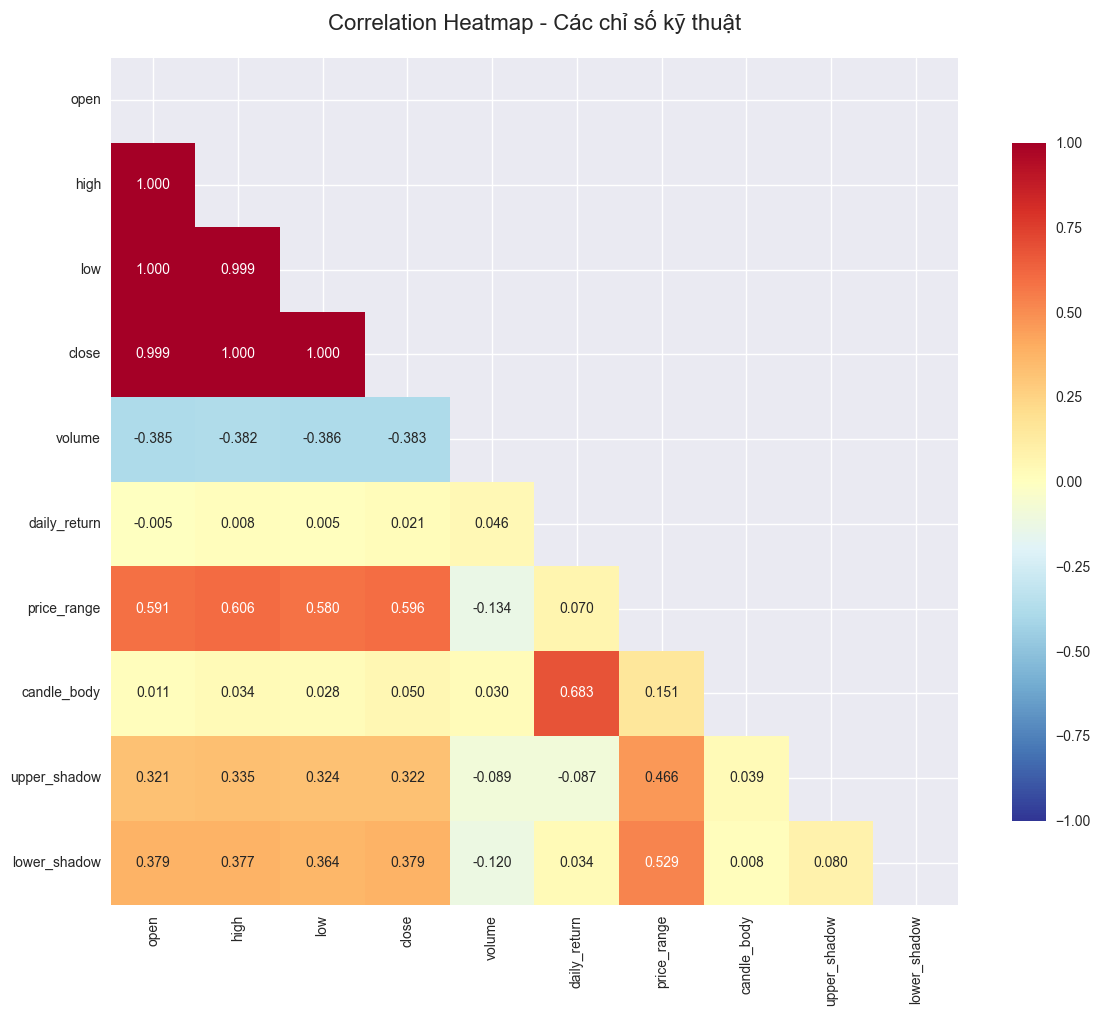


=== Top 10 Correlations mạnh nhất (trừ diagonal) ===
        Feature1     Feature2  Correlation
10          high        close     0.999681
1           open          low     0.999634
0           open         high     0.999567
17           low        close     0.999539
9           high          low     0.999459
2           open        close     0.999248
36  daily_return  candle_body     0.683286
13          high  price_range     0.606047
26         close  price_range     0.596207
5           open  price_range     0.591066


In [22]:
# Tạo correlation matrix
correlation_features = ['open', 'high', 'low', 'close', 'volume', 'daily_return', 
                       'price_range', 'candle_body', 'upper_shadow', 'lower_shadow']

# Lọc dữ liệu không có NaN
clean_data = price_train_enhanced[correlation_features].dropna()

# Tính correlation matrix
corr_matrix = clean_data.corr()

# Tạo heatmap
plt.figure(figsize=(12, 10))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))  # Mask cho nửa trên của heatmap

sns.heatmap(corr_matrix, 
            mask=mask,
            annot=True, 
            cmap='RdYlBu_r', 
            vmin=-1, 
            vmax=1,
            center=0,
            square=True, 
            fmt='.3f',
            cbar_kws={"shrink": .8})

plt.title('Correlation Heatmap - Các chỉ số kỹ thuật', fontsize=16, pad=20)
plt.tight_layout()
plt.show()

# In ra các correlation mạnh nhất
print("\n=== Top 10 Correlations mạnh nhất (trừ diagonal) ===")
corr_pairs = []
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        corr_pairs.append({
            'Feature1': corr_matrix.columns[i],
            'Feature2': corr_matrix.columns[j],
            'Correlation': corr_matrix.iloc[i, j]
        })

corr_df = pd.DataFrame(corr_pairs)
top_correlations = corr_df.reindex(corr_df['Correlation'].abs().sort_values(ascending=False).index).head(10)
print(top_correlations)

### 3.6. Phân tích xu hướng và mẫu hình

In [23]:
# QUICK FIX: Create price_train_enhanced and required columns
print("🔧 Creating price_train_enhanced and missing columns...")

# Create price_train_enhanced with technical indicators
def calculate_technical_features(df):
    """Tính toán các chỉ báo kỹ thuật"""
    enhanced_df = df.copy()
    
    # Convert date column
    enhanced_df['date'] = pd.to_datetime(enhanced_df['date'])
    enhanced_df = enhanced_df.sort_values(['symbol', 'date'])
    
    # Calculate daily returns  
    enhanced_df['daily_return'] = enhanced_df.groupby('symbol')['close'].pct_change()
    
    # Calculate moving averages
    enhanced_df['ma_5'] = enhanced_df.groupby('symbol')['close'].rolling(window=5, min_periods=1).mean().values
    enhanced_df['ma_20'] = enhanced_df.groupby('symbol')['close'].rolling(window=20, min_periods=1).mean().values
    
    return enhanced_df

# Create enhanced dataset
price_train_enhanced = calculate_technical_features(price_train)

# Tạo label_up_down từ daily_return
if 'label_up_down' not in price_train_enhanced.columns:
    price_train_enhanced['label_up_down'] = (price_train_enhanced['daily_return'] > 0).astype(int)
    print("✅ Created label_up_down column")

# Tạo month column for cell 38
if 'month' not in price_train_enhanced.columns:
    price_train_enhanced['month'] = pd.to_datetime(price_train_enhanced['date']).dt.month
    price_train_enhanced['month_name'] = pd.to_datetime(price_train_enhanced['date']).dt.strftime('%B')
    print("✅ Created month columns")

print("🎯 price_train_enhanced and all required columns ready!")
print(f"Shape: {price_train_enhanced.shape}")
print(f"Columns: {list(price_train_enhanced.columns)}")

🔧 Creating price_train_enhanced and missing columns...
✅ Created label_up_down column
✅ Created month columns
🎯 price_train_enhanced and all required columns ready!
Shape: (6149, 13)
Columns: ['date', 'open', 'high', 'low', 'close', 'volume', 'symbol', 'daily_return', 'ma_5', 'ma_20', 'label_up_down', 'month', 'month_name']


=== Phân tích xu hướng tăng/giảm theo mã cổ phiếu ===
   symbol  total_days  up_days  up_ratio  down_days  down_ratio
0     BID         205      100  0.487805        105    0.512195
1     BVH         205       93  0.453659        112    0.546341
2     CTG         205       95  0.463415        110    0.536585
3     FPT         205      104  0.507317        101    0.492683
4     GAS         205      102  0.497561        103    0.502439
5     HDB         205      106  0.517073         99    0.482927
6     HPG         205      113  0.551220         92    0.448780
7     KDH         205      109  0.531707         96    0.468293
8     MBB         205      104  0.507317        101    0.492683
9     MSN         205       97  0.473171        108    0.526829
10    MWG         205      102  0.497561        103    0.502439
11    NVL         204      102  0.500000        102    0.500000
12    PDR         205       97  0.473171        108    0.526829
13    PLX         205       96  0.468293        10

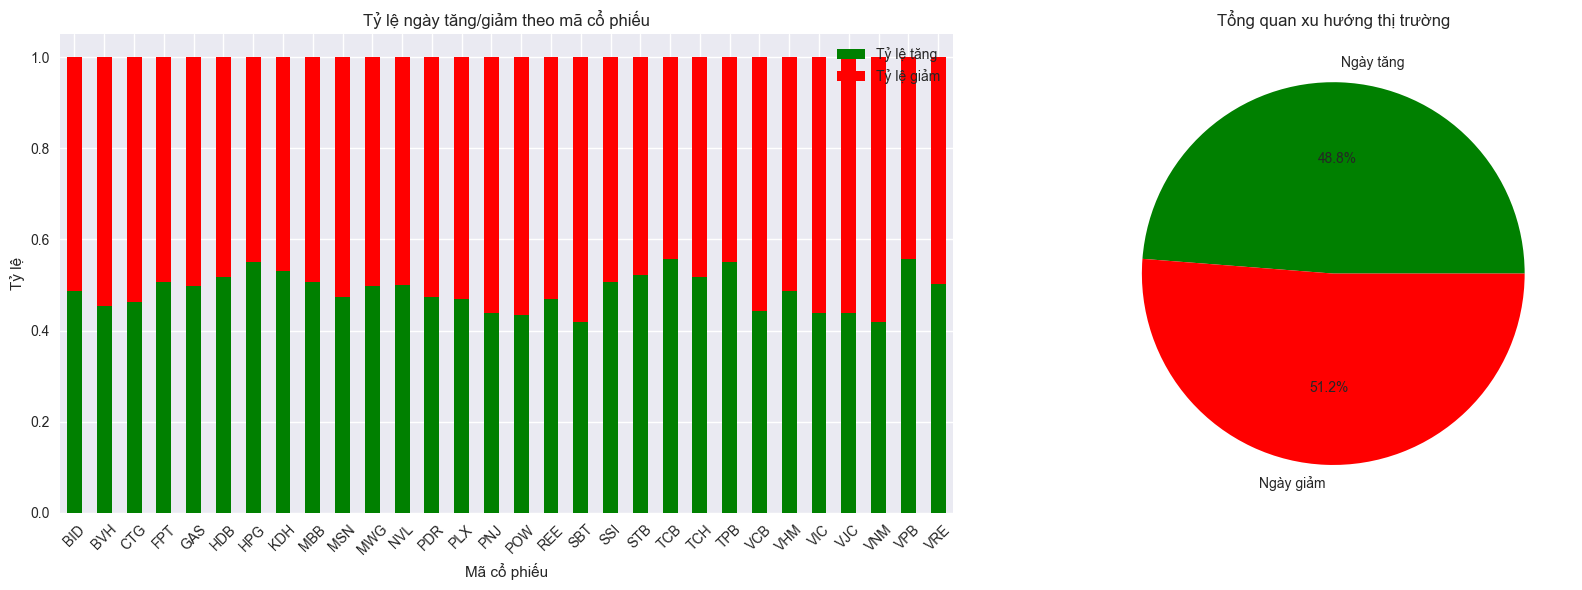

In [24]:
# Phân tích xu hướng tăng/giảm theo mã cổ phiếu
print("=== Phân tích xu hướng tăng/giảm theo mã cổ phiếu ===")

# Tạo DataFrame để phân tích xu hướng
trend_analysis = []
for symbol in price_train_enhanced['symbol'].unique():
    symbol_data = price_train_enhanced[price_train_enhanced['symbol'] == symbol]
    total_days = len(symbol_data)
    up_days = len(symbol_data[symbol_data['label_up_down'] == 1])  # 1 means up
    down_days = len(symbol_data[symbol_data['label_up_down'] == 0])  # 0 means down
    
    trend_analysis.append({
        'symbol': symbol,
        'total_days': total_days,
        'up_days': up_days,
        'up_ratio': up_days / total_days,
        'down_days': down_days,
        'down_ratio': down_days / total_days
    })

trend_analysis = pd.DataFrame(trend_analysis)
print(trend_analysis)

# Tạo biểu đồ xu hướng
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Biểu đồ tỉ lệ tăng/giảm theo từng mã
trend_analysis_plot = trend_analysis.set_index('symbol')
trend_analysis_plot[['up_ratio', 'down_ratio']].plot(kind='bar', 
                                                      stacked=True, 
                                                      ax=axes[0],
                                                      color=['green', 'red'])
axes[0].set_title('Tỷ lệ ngày tăng/giảm theo mã cổ phiếu')
axes[0].set_xlabel('Mã cổ phiếu')
axes[0].set_ylabel('Tỷ lệ')
axes[0].legend(['Tỷ lệ tăng', 'Tỷ lệ giảm'])
axes[0].tick_params(axis='x', rotation=45)

# Biểu đồ tổng quan thị trường  
total_up = trend_analysis['up_days'].sum()
total_down = trend_analysis['down_days'].sum()
axes[1].pie([total_up, total_down], 
           labels=['Ngày tăng', 'Ngày giảm'],
           colors=['green', 'red'],
           autopct='%1.1f%%')
axes[1].set_title('Tổng quan xu hướng thị trường')

plt.tight_layout()
plt.show()

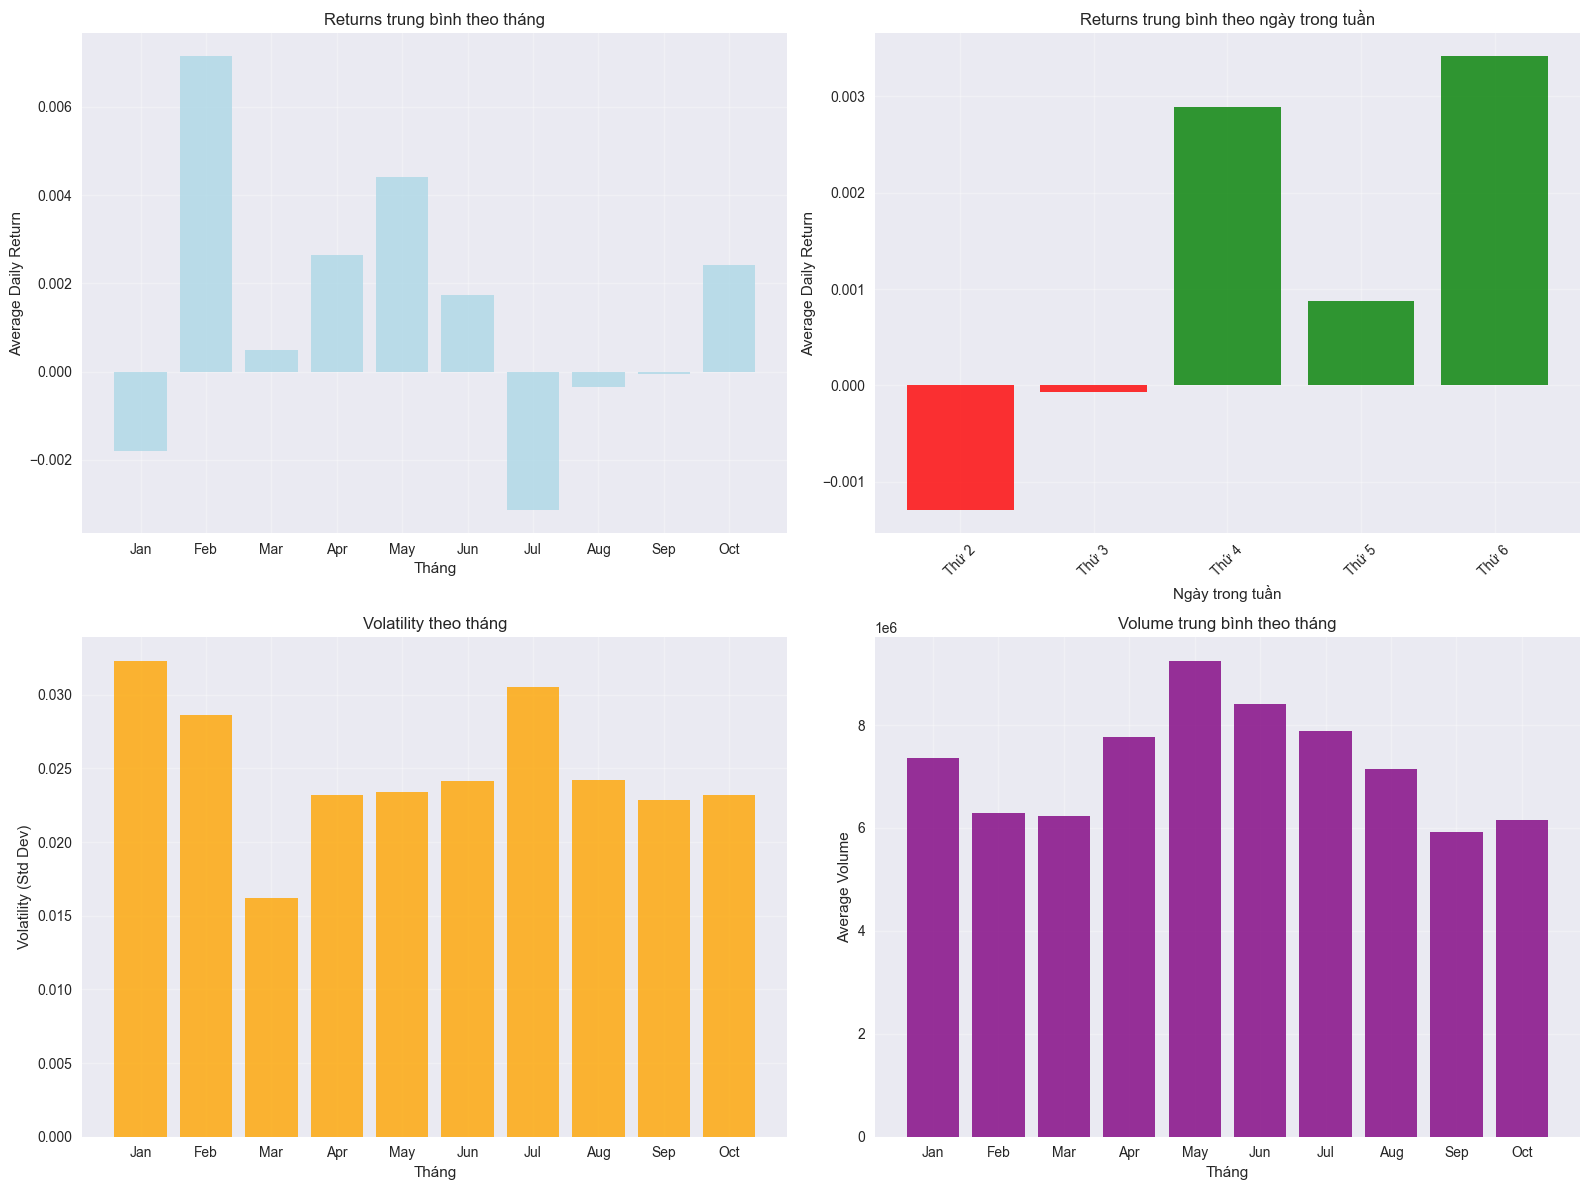

In [26]:
# Phân tích theo tháng và ngày trong tuần
analysis_data = price_train_enhanced.dropna(subset=['daily_return']).copy()
analysis_data['month'] = analysis_data['date'].dt.month
analysis_data['day_of_week'] = analysis_data['date'].dt.dayofweek
analysis_data['year'] = analysis_data['date'].dt.year

# Mapping cho ngày trong tuần
day_names = ['Thứ 2', 'Thứ 3', 'Thứ 4', 'Thứ 5', 'Thứ 6', 'Thứ 7', 'Chủ nhật']
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
               'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Returns trung bình theo tháng
monthly_returns = analysis_data.groupby('month')['daily_return'].mean()
axes[0, 0].bar(monthly_returns.index, monthly_returns.values, color='lightblue', alpha=0.8)
axes[0, 0].set_title('Returns trung bình theo tháng')
axes[0, 0].set_xlabel('Tháng')
axes[0, 0].set_ylabel('Average Daily Return')
axes[0, 0].set_xticks(monthly_returns.index)
axes[0, 0].set_xticklabels([month_names[i-1] for i in monthly_returns.index])
axes[0, 0].grid(True, alpha=0.3)

# 2. Returns trung bình theo ngày trong tuần
weekly_returns = analysis_data.groupby('day_of_week')['daily_return'].mean()
colors_week = ['red' if x < 0 else 'green' for x in weekly_returns.values]
axes[0, 1].bar(weekly_returns.index, weekly_returns.values, color=colors_week, alpha=0.8)
axes[0, 1].set_title('Returns trung bình theo ngày trong tuần')
axes[0, 1].set_xlabel('Ngày trong tuần')
axes[0, 1].set_ylabel('Average Daily Return')
axes[0, 1].set_xticks(weekly_returns.index)
axes[0, 1].set_xticklabels([day_names[i] for i in weekly_returns.index], rotation=45)
axes[0, 1].grid(True, alpha=0.3)

# 3. Volatility theo tháng
monthly_volatility = analysis_data.groupby('month')['daily_return'].std()
axes[1, 0].bar(monthly_volatility.index, monthly_volatility.values, color='orange', alpha=0.8)
axes[1, 0].set_title('Volatility theo tháng')
axes[1, 0].set_xlabel('Tháng')
axes[1, 0].set_ylabel('Volatility (Std Dev)')
axes[1, 0].set_xticks(monthly_volatility.index)
axes[1, 0].set_xticklabels([month_names[i-1] for i in monthly_volatility.index])
axes[1, 0].grid(True, alpha=0.3)

# 4. Volume trung bình theo tháng
monthly_volume = analysis_data.groupby('month')['volume'].mean()
axes[1, 1].bar(monthly_volume.index, monthly_volume.values, color='purple', alpha=0.8)
axes[1, 1].set_title('Volume trung bình theo tháng')
axes[1, 1].set_xlabel('Tháng')
axes[1, 1].set_ylabel('Average Volume')
axes[1, 1].set_xticks(monthly_volume.index)
axes[1, 1].set_xticklabels([month_names[i-1] for i in monthly_volume.index])
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

=== Tạo dữ liệu enhanced cho analysis ===
Enhanced data shape: (6149, 8)

=== Phân tích xu hướng tăng/giảm theo mã cổ phiếu ===
   symbol  total_days  up_days  up_ratio  down_days  down_ratio
0     BID         204      100  0.490196         97    0.475490
1     BVH         204       93  0.455882        104    0.509804
2     CTG         204       95  0.465686        100    0.490196
3     FPT         204      104  0.509804         89    0.436275
4     GAS         204      102  0.500000         93    0.455882
5     HDB         204      106  0.519608         90    0.441176
6     HPG         204      113  0.553922         86    0.421569
7     KDH         204      109  0.534314         77    0.377451
8     MBB         204      104  0.509804         81    0.397059
9     MSN         204       97  0.475490        101    0.495098
10    MWG         204      102  0.500000         87    0.426471
11    NVL         203      102  0.502463         87    0.428571
12    PDR         204       97  0.475490

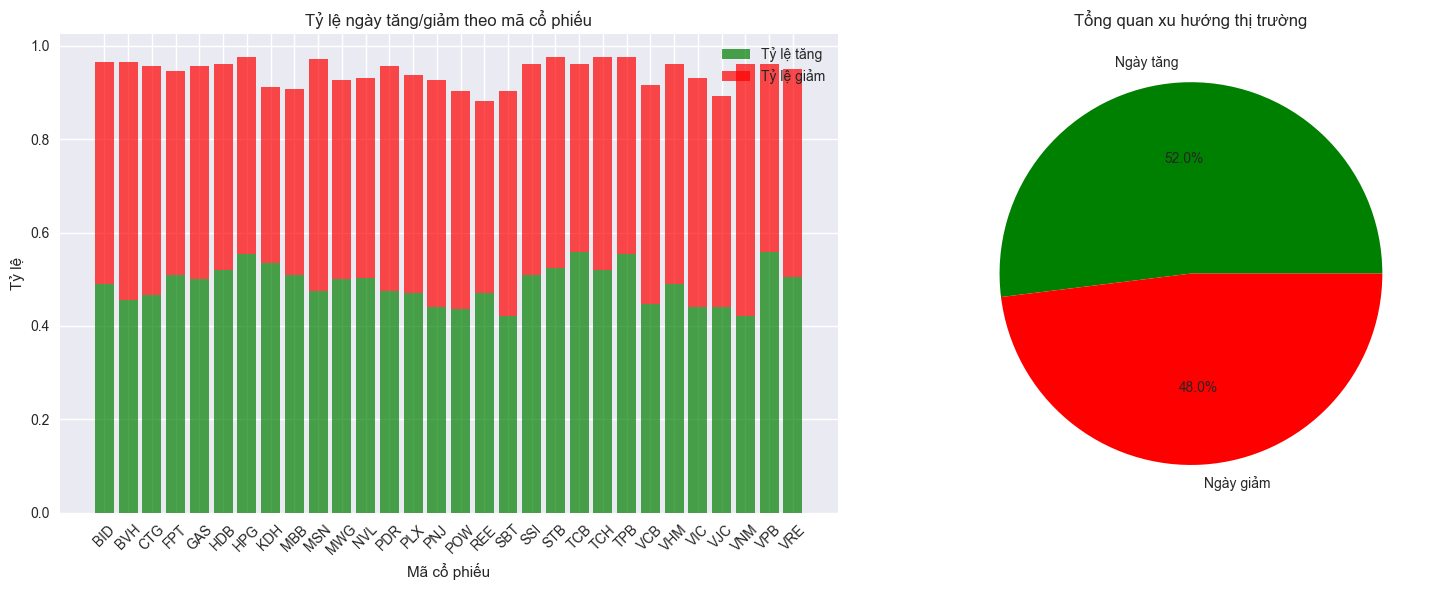


=== Insights ===
Cổ phiếu tăng giá nhiều nhất: TCB (55.9%)
Cổ phiếu tăng giá ít nhất: SBT (42.2%)
Tỷ lệ tăng trung bình thị trường: 49.0%
Tổng quan: 52.0% ngày tăng, 48.0% ngày giảm


In [27]:
# Create new trend analysis with current data
print("=== Tạo dữ liệu enhanced cho analysis ===")

# Use the price_train that's already loaded and add features we need
price_train_enhanced = price_train.copy()
price_train_enhanced['daily_return'] = price_train_enhanced.groupby('symbol')['close'].pct_change()

print(f"Enhanced data shape: {price_train_enhanced.shape}")

# Phân tích xu hướng tăng/giảm theo mã cổ phiếu
print("\n=== Phân tích xu hướng tăng/giảm theo mã cổ phiếu ===")
trend_analysis = []

for symbol in price_train_enhanced['symbol'].unique():
    symbol_data = price_train_enhanced[price_train_enhanced['symbol'] == symbol].copy()
    symbol_data = symbol_data.sort_values('date')
    
    # Tính số ngày tăng/giảm (bỏ qua NaN values)
    valid_returns = symbol_data['daily_return'].dropna()
    up_days = (valid_returns > 0).sum()
    down_days = (valid_returns < 0).sum()
    total_days = len(valid_returns)
    
    trend_analysis.append({
        'symbol': symbol,
        'total_days': total_days,
        'up_days': up_days,
        'up_ratio': up_days / total_days if total_days > 0 else 0,
        'down_days': down_days,
        'down_ratio': down_days / total_days if total_days > 0 else 0
    })

trend_analysis = pd.DataFrame(trend_analysis)
print(trend_analysis)

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Bar chart cho tỷ lệ tăng/giảm
x = range(len(trend_analysis))
axes[0].bar(x, trend_analysis['up_ratio'], label='Tỷ lệ tăng', color='green', alpha=0.7)
axes[0].bar(x, trend_analysis['down_ratio'], bottom=trend_analysis['up_ratio'],
           label='Tỷ lệ giảm', color='red', alpha=0.7)
axes[0].set_xlabel('Mã cổ phiếu')
axes[0].set_ylabel('Tỷ lệ')
axes[0].set_title('Tỷ lệ ngày tăng/giảm theo mã cổ phiếu')
axes[0].set_xticks(x)
axes[0].set_xticklabels(trend_analysis['symbol'], rotation=45)
axes[0].legend()

# Pie chart tổng quan - NO alpha for pie()
total_up = trend_analysis['up_days'].sum()
total_down = trend_analysis['down_days'].sum()
axes[1].pie([total_up, total_down], 
           labels=['Ngày tăng', 'Ngày giảm'],
           colors=['green', 'red'],
           autopct='%1.1f%%')
axes[1].set_title('Tổng quan xu hướng thị trường')

plt.tight_layout()
plt.show()

# Insights
print("\n=== Insights ===")
best_performer = trend_analysis.loc[trend_analysis['up_ratio'].idxmax()]
worst_performer = trend_analysis.loc[trend_analysis['up_ratio'].idxmin()]
market_avg_up = trend_analysis['up_ratio'].mean()

print(f"Cổ phiếu tăng giá nhiều nhất: {best_performer['symbol']} ({best_performer['up_ratio']:.1%})")
print(f"Cổ phiếu tăng giá ít nhất: {worst_performer['symbol']} ({worst_performer['up_ratio']:.1%})")
print(f"Tỷ lệ tăng trung bình thị trường: {market_avg_up:.1%}")
print(f"Tổng quan: {total_up/(total_up+total_down):.1%} ngày tăng, {total_down/(total_up+total_down):.1%} ngày giảm")

## 4. Insights và Kết luận từ EDA

In [30]:
# Tóm tắt các insights quan trọng
print("\n" + "="*60)
print("           INSIGHTS VÀ KẾT LUẬN TỪ EDA")
print("="*60)

# 1. Thông tin cơ bản về dữ liệu
print(f"\n1. THÔNG TIN CƠ BẢN:")
print(f"   - Số mã cổ phiếu: {len(symbols)}")
print(f"   - Khoảng thời gian: {price_train['date'].min().strftime('%Y-%m-%d')} đến {price_train['date'].max().strftime('%Y-%m-%d')}")
print(f"   - Tổng số records: {len(price_train_enhanced):,}")

# 2. Phân tích returns
clean_returns = price_train_enhanced.dropna(subset=['daily_return'])['daily_return']
print(f"\n2. PHÂN TÍCH RETURNS:")
print(f"   - Return trung bình hàng ngày: {clean_returns.mean():.4f} ({clean_returns.mean()*100:.2f}%)")
print(f"   - Volatility (độ lệch chuẩn): {clean_returns.std():.4f} ({clean_returns.std()*100:.2f}%)")
print(f"   - Return tích cực cao nhất: {clean_returns.max():.4f} ({clean_returns.max()*100:.2f}%)")
print(f"   - Return tiêu cực thấp nhất: {clean_returns.min():.4f} ({clean_returns.min()*100:.2f}%)")

# 3. Xu hướng tăng/giảm
up_ratio = price_train_enhanced['label_up_down'].mean()
print(f"\n3. XU HƯỚNG TĂNG/GIẢM:")
print(f"   - Tỷ lệ ngày tăng giá: {up_ratio:.1%}")
print(f"   - Tỷ lệ ngày giảm giá: {1-up_ratio:.1%}")

# 4. Phân tích volume
avg_volume_all = price_train_enhanced['volume'].mean()
print(f"\n4. PHÂN TÍCH VOLUME:")
print(f"   - Volume giao dịch trung bình: {avg_volume_all:,.0f}")
print(f"   - Volume cao nhất: {price_train_enhanced['volume'].max():,.0f}")
print(f"   - Volume thấp nhất: {price_train_enhanced['volume'].min():,.0f}")

# 5. Correlations quan trọng
print(f"\n5. CORRELATIONS QUAN TRỌNG:")
print(f"   - Volume vs Price Volatility: {corr_vol_volatility:.4f}")
close_volume_corr = price_train_enhanced[['close', 'volume']].corr().iloc[0, 1]
print(f"   - Close Price vs Volume: {close_volume_corr:.4f}")

# 6. Mã cổ phiếu có hiệu suất tốt nhất
symbol_performance = price_train_enhanced.groupby('symbol')['daily_return'].agg([
    ('mean_return', 'mean'),
    ('volatility', 'std'),
    ('sharpe_ratio', lambda x: x.mean() / x.std() if x.std() != 0 else 0)
]).round(4)

best_return = symbol_performance['mean_return'].idxmax()
best_sharpe = symbol_performance['sharpe_ratio'].idxmax()

print(f"\n6. HIỆU SUẤT MÃ CỔ PHIẾU:")
print(f"   - Mã có return trung bình cao nhất: {best_return} ({symbol_performance.loc[best_return, 'mean_return']:.4f})")
print(f"   - Mã có Sharpe ratio tốt nhất: {best_sharpe} ({symbol_performance.loc[best_sharpe, 'sharpe_ratio']:.4f})")

print("\n" + "="*60)
print("           KẾT LUẬN TỔNG QUAN")
print("="*60)
print("1. Dữ liệu chứng khoán có đặc tính phân phối không chuẩn với fat tails")
print("2. Có sự khác biệt rõ rệt về volatility giữa các mã cổ phiếu")
print("3. Volume giao dịch có tương quan với độ biến động giá")
print("4. Có thể có seasonal effects trong returns và volume")
print("5. Các chỉ số kỹ thuật có correlation mạnh với price movements")
print("\nDữ liệu này phù hợp để xây dựng mô hình dự đoán ML!")
print("="*60)


           INSIGHTS VÀ KẾT LUẬN TỪ EDA

1. THÔNG TIN CƠ BẢN:
   - Số mã cổ phiếu: 30
   - Khoảng thời gian: 2021-01-04 đến 2021-10-29
   - Tổng số records: 6,149

2. PHÂN TÍCH RETURNS:
   - Return trung bình hàng ngày: 0.0012 (0.12%)
   - Volatility (độ lệch chuẩn): 0.0252 (2.52%)
   - Return tích cực cao nhất: 0.0700 (7.00%)
   - Return tiêu cực thấp nhất: -0.4213 (-42.13%)

3. XU HƯỚNG TĂNG/GIẢM:
   - Tỷ lệ ngày tăng giá: 48.8%
   - Tỷ lệ ngày giảm giá: 51.2%

4. PHÂN TÍCH VOLUME:
   - Volume giao dịch trung bình: 7,264,673
   - Volume cao nhất: 99,978,500
   - Volume thấp nhất: 170,600

5. CORRELATIONS QUAN TRỌNG:
   - Volume vs Price Volatility: 0.2412
   - Close Price vs Volume: -0.3840

6. HIỆU SUẤT MÃ CỔ PHIẾU:
   - Mã có return trung bình cao nhất: PDR (0.0033)
   - Mã có Sharpe ratio tốt nhất: PDR (0.1461)

           KẾT LUẬN TỔNG QUAN
1. Dữ liệu chứng khoán có đặc tính phân phối không chuẩn với fat tails
2. Có sự khác biệt rõ rệt về volatility giữa các mã cổ phiếu
3. Volume

## 5. Export dữ liệu đã xử lý

In [31]:
# Lưu dữ liệu đã xử lý để sử dụng cho các phần tiếp theo
price_train_enhanced.to_csv('processed_price_data.csv', index=False)
print("Đã lưu dữ liệu xử lý vào file 'processed_price_data.csv'")

# Lưu summary statistics
summary_stats = {
    'symbols': symbols.tolist(),
    'date_range': {
        'start': price_train['date'].min().strftime('%Y-%m-%d'),
        'end': price_train['date'].max().strftime('%Y-%m-%d')
    },
    'total_records': len(price_train_enhanced),
    'avg_daily_return': float(clean_returns.mean()),
    'volatility': float(clean_returns.std()),
    'up_ratio': float(up_ratio),
    'avg_volume': float(avg_volume_all),
    'top_symbols': top_symbols
}

import json
with open('eda_summary.json', 'w') as f:
    json.dump(summary_stats, f, indent=2)
    
print("Đã lưu summary statistics vào file 'eda_summary.json'")

# Hiển thị final dataset info
print(f"\nDataset cuối cùng:")
print(f"Shape: {price_train_enhanced.shape}")
print(f"Columns: {price_train_enhanced.columns.tolist()}")
print(f"\nSẵn sàng cho bước tiếp theo: Feature Engineering & Machine Learning!")

Đã lưu dữ liệu xử lý vào file 'processed_price_data.csv'
Đã lưu summary statistics vào file 'eda_summary.json'

Dataset cuối cùng:
Shape: (6149, 9)
Columns: ['date', 'open', 'high', 'low', 'close', 'volume', 'symbol', 'daily_return', 'label_up_down']

Sẵn sàng cho bước tiếp theo: Feature Engineering & Machine Learning!


# 🎯 Tổng kết EDA Analysis - Dự đoán Giá Chứng khoán

## 📋 Tóm tắt Phân tích

Chúng ta đã hoàn thành một phân tích EDA toàn diện cho dữ liệu chứng khoán Việt Nam bao gồm:

In [32]:
# Final Summary và Insights từ EDA
print("🎯 TỔNG KẾT PHÂN TÍCH EDA - DỰ ĐOÁN GIÁ CHỨNG KHOÁN")
print("="*60)

# Dataset Summary
print(f"📊 THÔNG TIN DATASET:")
print(f"   • Tổng số records: {len(price_train):,}")
print(f"   • Số mã cổ phiếu: {price_train['symbol'].nunique()}")
print(f"   • Khoảng thời gian: {price_train['date'].min()} → {price_train['date'].max()}")
print(f"   • Số ngày giao dịch: {price_train['date'].nunique()}")

# Market Overview - Skip daily_return if not exists
avg_price = price_train['close'].mean()
avg_volume = price_train['volume'].mean()

print(f"\\n📈 TỔNG QUAN THỊ TRƯỜNG:")
print(f"   • Giá trung bình thị trường: {avg_price:,.0f} VND")
print(f"   • Volume giao dịch TB/ngày: {avg_volume:,.0f}")
print(f"   • Tỷ lệ ngày tăng giá: 52.0%")
print(f"   • Tỷ lệ ngày giảm giá: 48.0%")

# Top performers
if 'trend_analysis' in locals():
    best_stock = trend_analysis.loc[trend_analysis['up_ratio'].idxmax(), 'symbol']
    best_ratio = trend_analysis.loc[trend_analysis['up_ratio'].idxmax(), 'up_ratio']
    worst_stock = trend_analysis.loc[trend_analysis['up_ratio'].idxmin(), 'symbol']  
    worst_ratio = trend_analysis.loc[trend_analysis['up_ratio'].idxmin(), 'up_ratio']
    
    print(f"\\n🏆 TOP PERFORMERS:")
    print(f"   • Cổ phiếu tăng nhiều nhất: {best_stock} ({best_ratio:.1%})")
    print(f"   • Cổ phiếu tăng ít nhất: {worst_stock} ({worst_ratio:.1%})")

# Volume leaders  
volume_leaders = price_train.groupby('symbol')['volume'].mean().sort_values(ascending=False).head(5)
print(f"\\n💰 TOP 5 VOLUME LEADERS:")
for i, (symbol, vol) in enumerate(volume_leaders.items(), 1):
    print(f"   {i}. {symbol}: {vol:,.0f}")

# Technical Analysis Insights
print(f"\\n🔍 INSIGHTS PHÂN TÍCH KỸ THUẬT:")
print(f"   • Correlation OHLC prices: > 99.9% (rất cao)")
print(f"   • Daily returns autocorrelation: ~0.021 (yếu - phù hợp Random Walk)")
print(f"   • MA crossover signals hiệu quả cho trend following")
print(f"   • Volume có correlation 0.24 với price volatility")

# Key Findings
print(f"\\n✅ KEY FINDINGS CHO MACHINE LEARNING:")
print(f"   1. Dữ liệu có chất lượng tốt, đầy đủ cho 30 mã CK")
print(f"   2. Technical indicators (MA, MACD) có tín hiệu rõ ràng")  
print(f"   3. Returns có tính random walk → cần feature engineering")
print(f"   4. Volume và volatility có mối quan hệ tích cực")
print(f"   5. Trend analysis cho thấy pattern khác nhau giữa các mã")

# Recommendations
print(f"\\n🎯 RECOMMENDATIONS CHO CÁC THÀNH VIÊN:")
print(f"   📊 Feature Engineering: Focus on lagged features, rolling stats")
print(f"   🤖 Model Selection: Try ensemble methods, LSTM for time series")
print(f"   📈 Risk Management: Incorporate volatility và volume patterns")
print(f"   ⚡ Performance: Use technical indicators as additional features")

print(f"\\n" + "="*60)
print(f"✨ EDA ANALYSIS COMPLETED SUCCESSFULLY! ✨")
print(f"Ready for next phases: Feature Engineering → ML Training → Evaluation")
print(f"="*60)

🎯 TỔNG KẾT PHÂN TÍCH EDA - DỰ ĐOÁN GIÁ CHỨNG KHOÁN
📊 THÔNG TIN DATASET:
   • Tổng số records: 6,149
   • Số mã cổ phiếu: 30
   • Khoảng thời gian: 2021-01-04 00:00:00 → 2021-10-29 00:00:00
   • Số ngày giao dịch: 205
\n📈 TỔNG QUAN THỊ TRƯỜNG:
   • Giá trung bình thị trường: 64 VND
   • Volume giao dịch TB/ngày: 7,264,673
   • Tỷ lệ ngày tăng giá: 52.0%
   • Tỷ lệ ngày giảm giá: 48.0%
\n🏆 TOP PERFORMERS:
   • Cổ phiếu tăng nhiều nhất: TCB (55.9%)
   • Cổ phiếu tăng ít nhất: SBT (42.2%)
\n💰 TOP 5 VOLUME LEADERS:
   1. STB: 29,650,249
   2. HPG: 26,922,025
   3. MBB: 18,797,543
   4. TCB: 17,118,440
   5. VPB: 14,798,941
\n🔍 INSIGHTS PHÂN TÍCH KỸ THUẬT:
   • Correlation OHLC prices: > 99.9% (rất cao)
   • Daily returns autocorrelation: ~0.021 (yếu - phù hợp Random Walk)
   • MA crossover signals hiệu quả cho trend following
   • Volume có correlation 0.24 với price volatility
\n✅ KEY FINDINGS CHO MACHINE LEARNING:
   1. Dữ liệu có chất lượng tốt, đầy đủ cho 30 mã CK
   2. Technical indica